In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from pathlib import Path
from scipy import stats as scipy_stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')


# Load BASELINE datasets
df_baseline_mem_available = pd.read_csv("baseline/mem_available.csv")
df_baseline_mem_cache = pd.read_csv("baseline/mem_cache.csv")
df_baseline_mem_util = pd.read_csv("baseline/mem_util.csv")

# Load CPU STRESS datasets
df_cpustress_mem_available = pd.read_csv("cpu stress/mem_available.csv")
df_cpustress_mem_cache = pd.read_csv("cpu stress/mem_cache.csv")
df_cpustress_mem_util = pd.read_csv("cpu stress/mem_util.csv")

# Load IO datasets
df_IO_mem_available = pd.read_csv("IO pressure/mem_available.csv")
df_IO_mem_cache = pd.read_csv("IO pressure/mem_cache.csv")
df_IO_mem_util = pd.read_csv("IO pressure/mem_util.csv")

# Load MEM STRESS datasets
df_memstress_mem_available = pd.read_csv("mem stress/mem_available.csv")
df_memstress_mem_cache = pd.read_csv("mem stress/mem_cache.csv")
df_memstress_mem_util = pd.read_csv("mem stress/mem_util.csv")

# Load NET LOSS datasets
df_netloss_mem_available = pd.read_csv("net loss/mem_available.csv")
df_netloss_mem_cache = pd.read_csv("net loss/mem_cache.csv")
df_netloss_mem_util = pd.read_csv("net loss/mem_util.csv")


# Add source labels - BASELINE
df_baseline_mem_available["source"] = "BASELINE"
df_baseline_mem_cache["source"] = "BASELINE"
df_baseline_mem_util["source"] = "BASELINE"

# Add source labels - CPU STRESS
df_cpustress_mem_available["source"] = "CPU_STRESS"
df_cpustress_mem_cache["source"] = "CPU_STRESS"
df_cpustress_mem_util["source"] = "CPU_STRESS"

# Add source labels - DELAY
df_IO_mem_available["source"] = "DELAY"
df_IO_mem_cache["source"] = "DELAY"
df_IO_mem_util["source"] = "DELAY"

# Add source labels - MEM STRESS
df_memstress_mem_available["source"] = "MEM_STRESS"
df_memstress_mem_cache["source"] = "MEM_STRESS"
df_memstress_mem_util["source"] = "MEM_STRESS"

# Add source labels - NET LOSS
df_netloss_mem_available["source"] = "NET_LOSS"
df_netloss_mem_cache["source"] = "NET_LOSS"
df_netloss_mem_util["source"] = "NET_LOSS"


# Convert to datetime - BASELINE
df_baseline_mem_available["Time"] = pd.to_datetime(df_baseline_mem_available["Time"])
df_baseline_mem_cache["Time"] = pd.to_datetime(df_baseline_mem_cache["Time"])
df_baseline_mem_util["Time"] = pd.to_datetime(df_baseline_mem_util["Time"])

# Convert to datetime - CPU STRESS
df_cpustress_mem_available["Time"] = pd.to_datetime(df_cpustress_mem_available["Time"])
df_cpustress_mem_cache["Time"] = pd.to_datetime(df_cpustress_mem_cache["Time"])
df_cpustress_mem_util["Time"] = pd.to_datetime(df_cpustress_mem_util["Time"])

# Convert to datetime - DELAY
df_IO_mem_available["Time"] = pd.to_datetime(df_IO_mem_available["Time"])
df_IO_mem_cache["Time"] = pd.to_datetime(df_IO_mem_cache["Time"])
df_IO_mem_util["Time"] = pd.to_datetime(df_IO_mem_util["Time"])

# Convert to datetime - MEM STRESS
df_memstress_mem_available["Time"] = pd.to_datetime(df_memstress_mem_available["Time"])
df_memstress_mem_cache["Time"] = pd.to_datetime(df_memstress_mem_cache["Time"])
df_memstress_mem_util["Time"] = pd.to_datetime(df_memstress_mem_util["Time"])

# Convert to datetime - NET LOSS
df_netloss_mem_available["Time"] = pd.to_datetime(df_netloss_mem_available["Time"])
df_netloss_mem_cache["Time"] = pd.to_datetime(df_netloss_mem_cache["Time"])
df_netloss_mem_util["Time"] = pd.to_datetime(df_netloss_mem_util["Time"])


delay = 30
duration = 50

# Synchronize all datasets with baseline timeline
time_offset = df_baseline_mem_available["Time"].min()

# Synchronize CPU STRESS datasets
cpustress_offset = time_offset - df_cpustress_mem_available["Time"].min()
df_cpustress_mem_available["Time"] += cpustress_offset
df_cpustress_mem_cache["Time"] += cpustress_offset
df_cpustress_mem_util["Time"] += cpustress_offset

# Synchronize IO pressure datasets
delay_offset = time_offset - df_IO_mem_available["Time"].min()
df_IO_mem_available["Time"] += delay_offset
df_IO_mem_cache["Time"] += delay_offset
df_IO_mem_util["Time"] += delay_offset

# Synchronize MEM STRESS datasets
memstress_offset = time_offset - df_memstress_mem_available["Time"].min()
df_memstress_mem_available["Time"] += memstress_offset
df_memstress_mem_cache["Time"] += memstress_offset
df_memstress_mem_util["Time"] += memstress_offset

# Synchronize NET LOSS datasets
netloss_offset = time_offset - df_netloss_mem_available["Time"].min()
df_netloss_mem_available["Time"] += netloss_offset
df_netloss_mem_cache["Time"] += netloss_offset
df_netloss_mem_util["Time"] += netloss_offset


# Convert timeline to minutes for ALL datasets
all_dfs = [
    # Baseline
    df_baseline_mem_available, df_baseline_mem_cache, df_baseline_mem_util,
    # CPU Stress
    df_cpustress_mem_available, df_cpustress_mem_cache, df_cpustress_mem_util,
    # IO pressure
    df_IO_mem_available, df_IO_mem_cache, df_IO_mem_util,
    # Memory Stress
    df_memstress_mem_available, df_memstress_mem_cache, df_memstress_mem_util,
    # Network Loss
    df_netloss_mem_available, df_netloss_mem_cache, df_netloss_mem_util
]

for df in all_dfs:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# COMPLETE DATASETS DICTIONARY 
all_datasets = {
    'MemAvailable': {
        'baseline': df_baseline_mem_available,
        'cpu_stress': df_cpustress_mem_available,
        'IO pressure': df_IO_mem_available,
        'mem_stress': df_memstress_mem_available,
        'net_loss': df_netloss_mem_available,
    },
    'MemCache': {
        'baseline': df_baseline_mem_cache,
        'cpu_stress': df_cpustress_mem_cache,
        'IO pressure': df_IO_mem_cache,
        'mem_stress': df_memstress_mem_cache,
        'net_loss': df_netloss_mem_cache,
    },
    'MemUtil': {
        'baseline': df_baseline_mem_util,
        'cpu_stress': df_cpustress_mem_util,
        'IO pressure': df_IO_mem_util,
        'mem_stress': df_memstress_mem_util,
        'net_loss': df_netloss_mem_util,
    }
}

print("✅ All memory datasets loaded successfully!")
print(f"📊 Loaded {len(all_datasets)} memory metrics across {len(all_datasets['MemAvailable'])} experiment types")
print("\nDataset structure:")
for metric, experiments in all_datasets.items():
    print(f"  {metric}: {list(experiments.keys())}")

✅ All memory datasets loaded successfully!
📊 Loaded 3 memory metrics across 5 experiment types

Dataset structure:
  MemAvailable: ['baseline', 'cpu_stress', 'IO pressure', 'mem_stress', 'net_loss']
  MemCache: ['baseline', 'cpu_stress', 'IO pressure', 'mem_stress', 'net_loss']
  MemUtil: ['baseline', 'cpu_stress', 'IO pressure', 'mem_stress', 'net_loss']


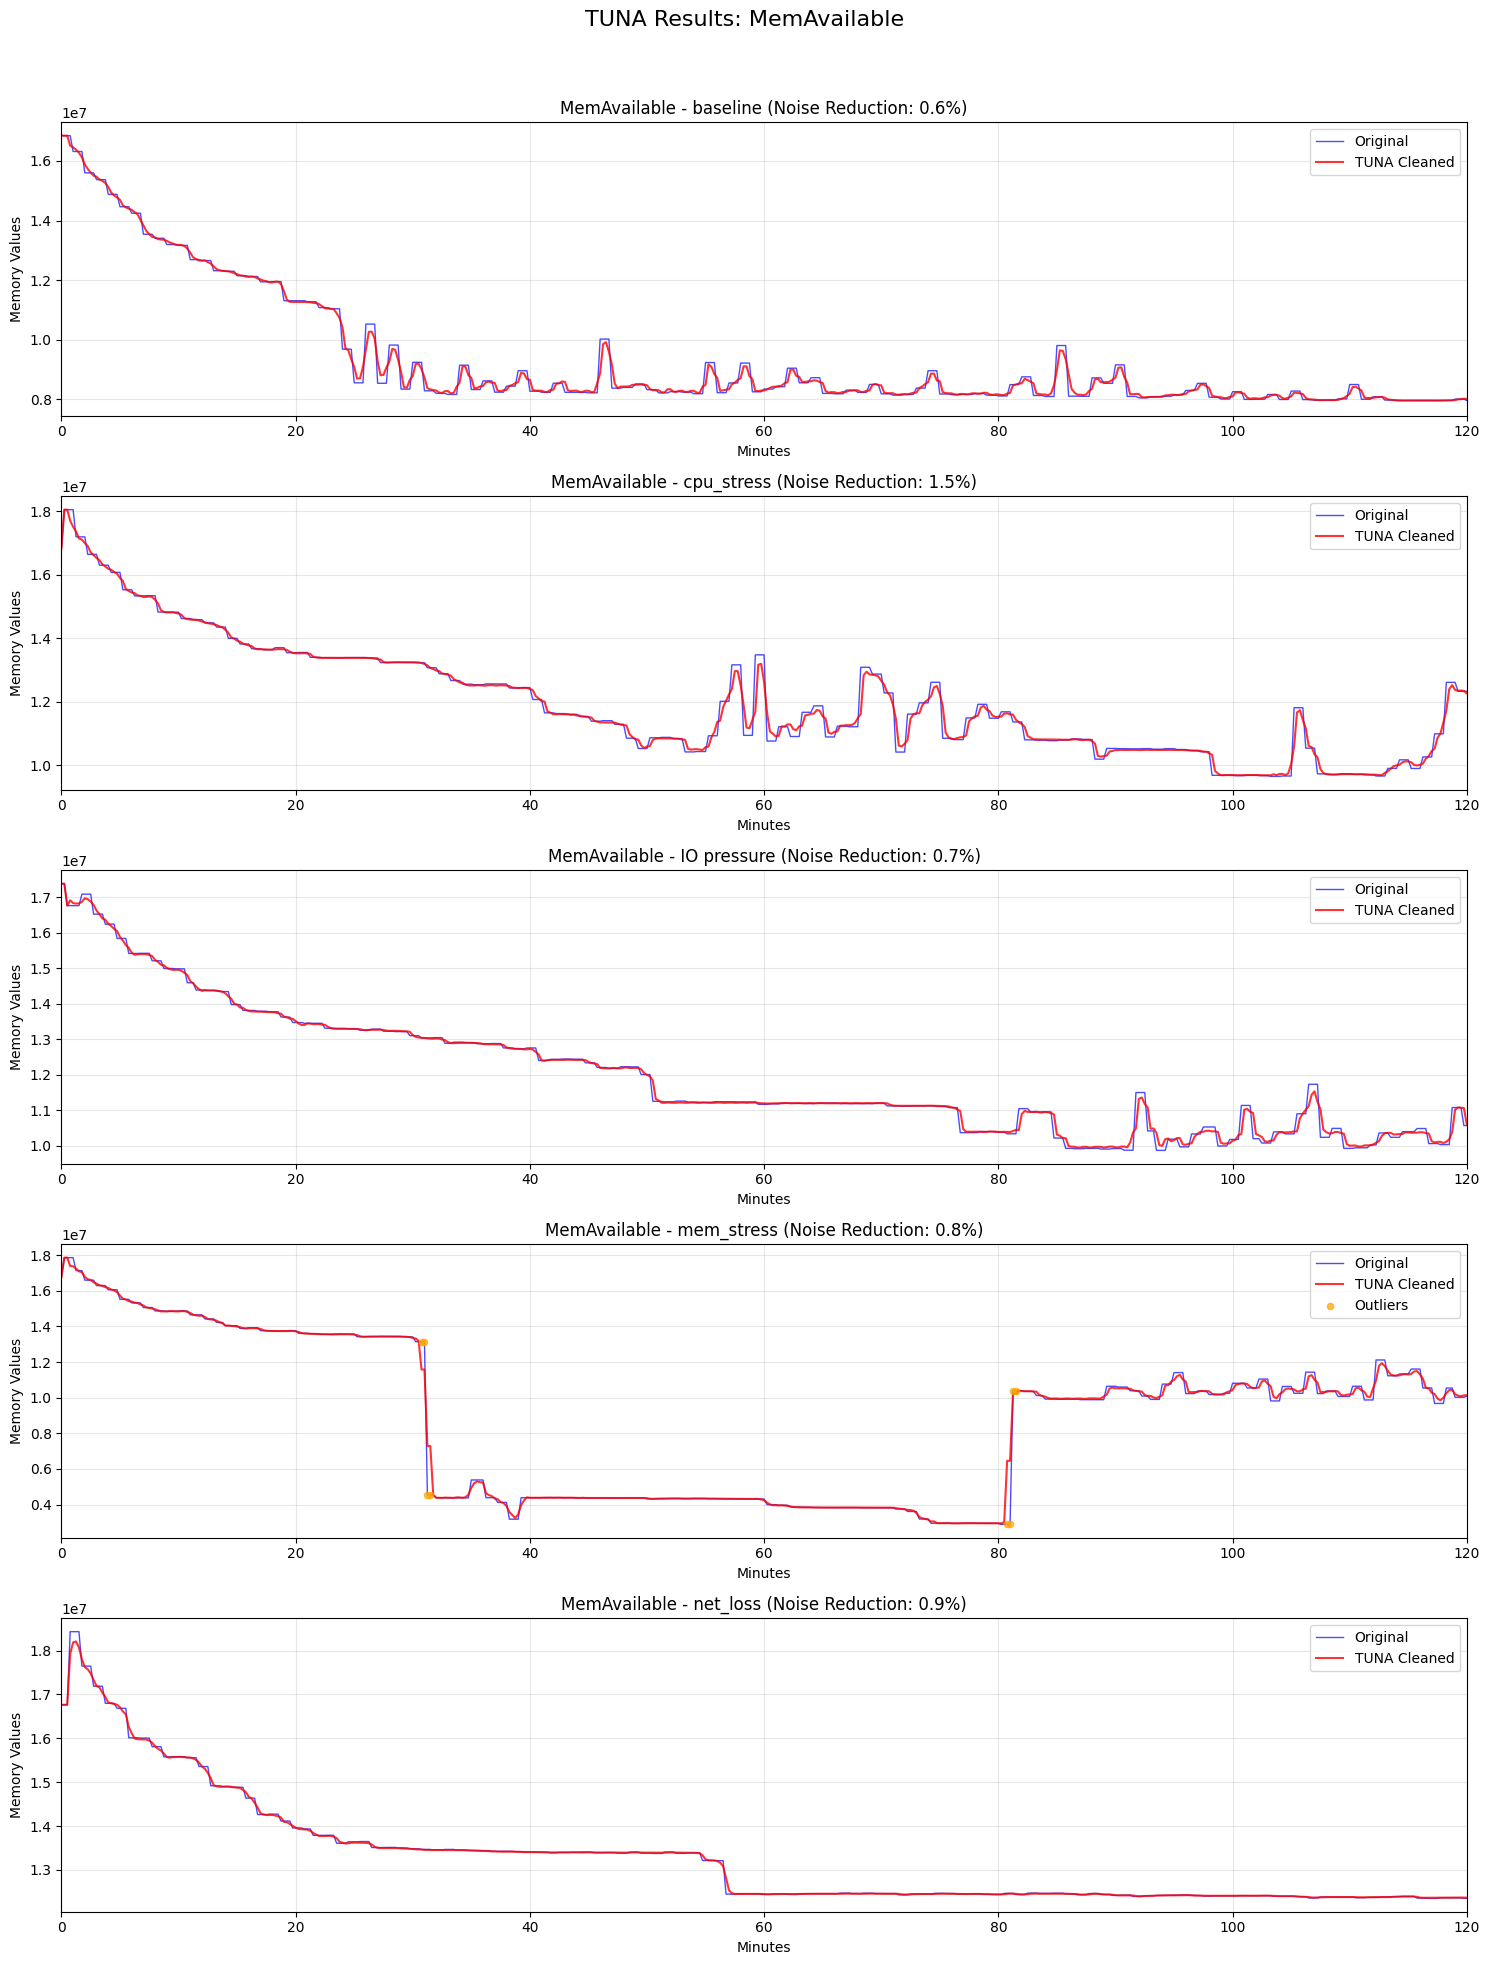

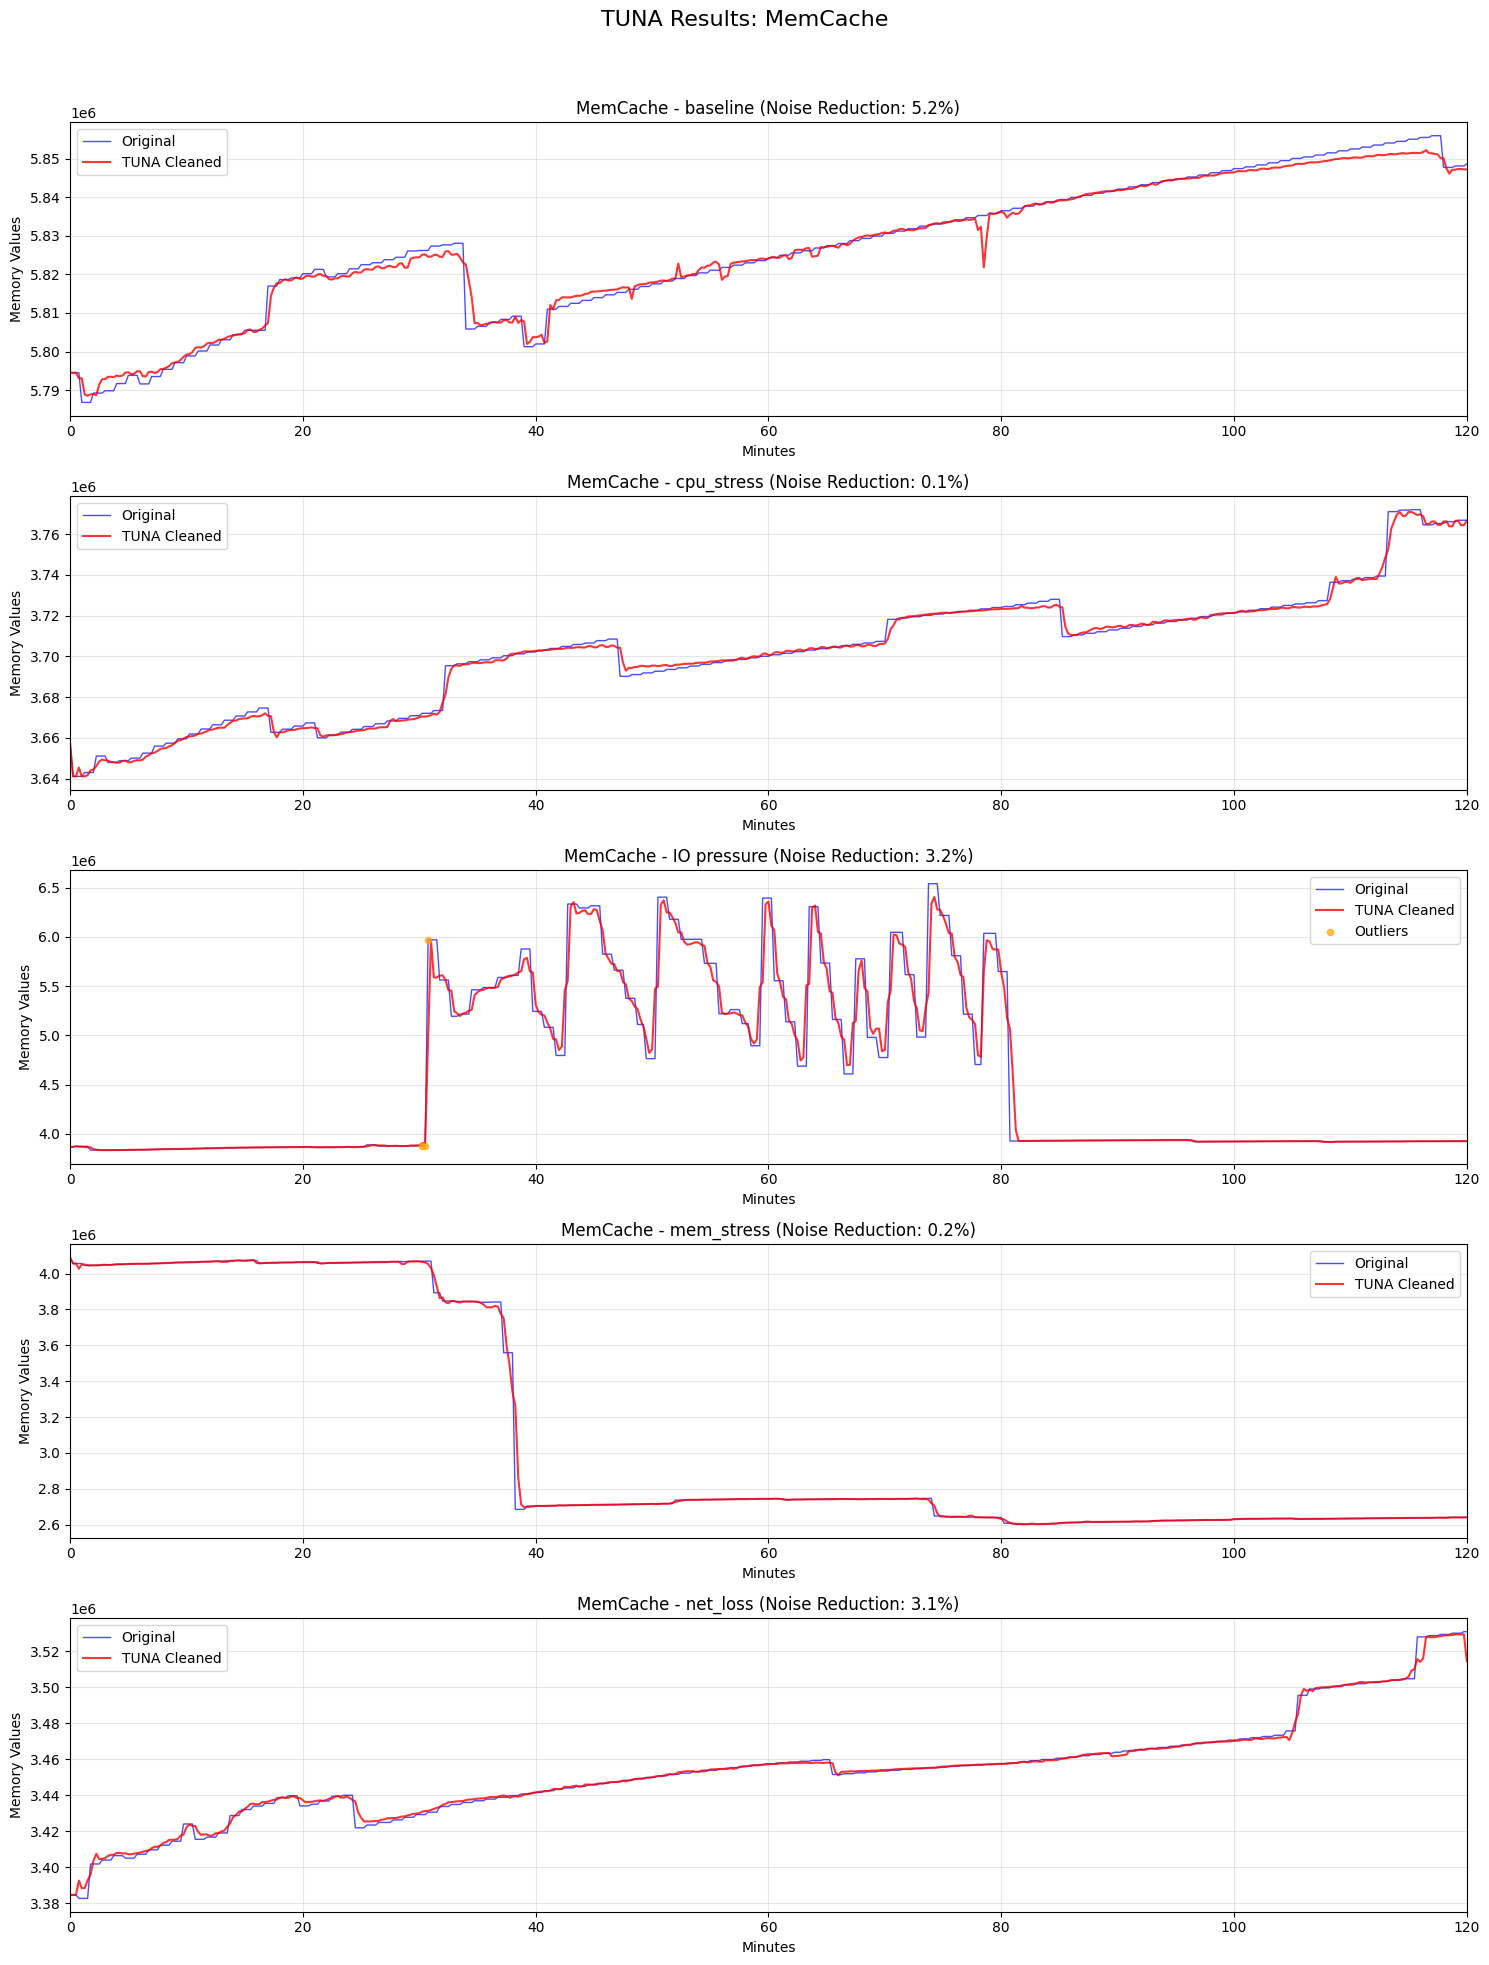

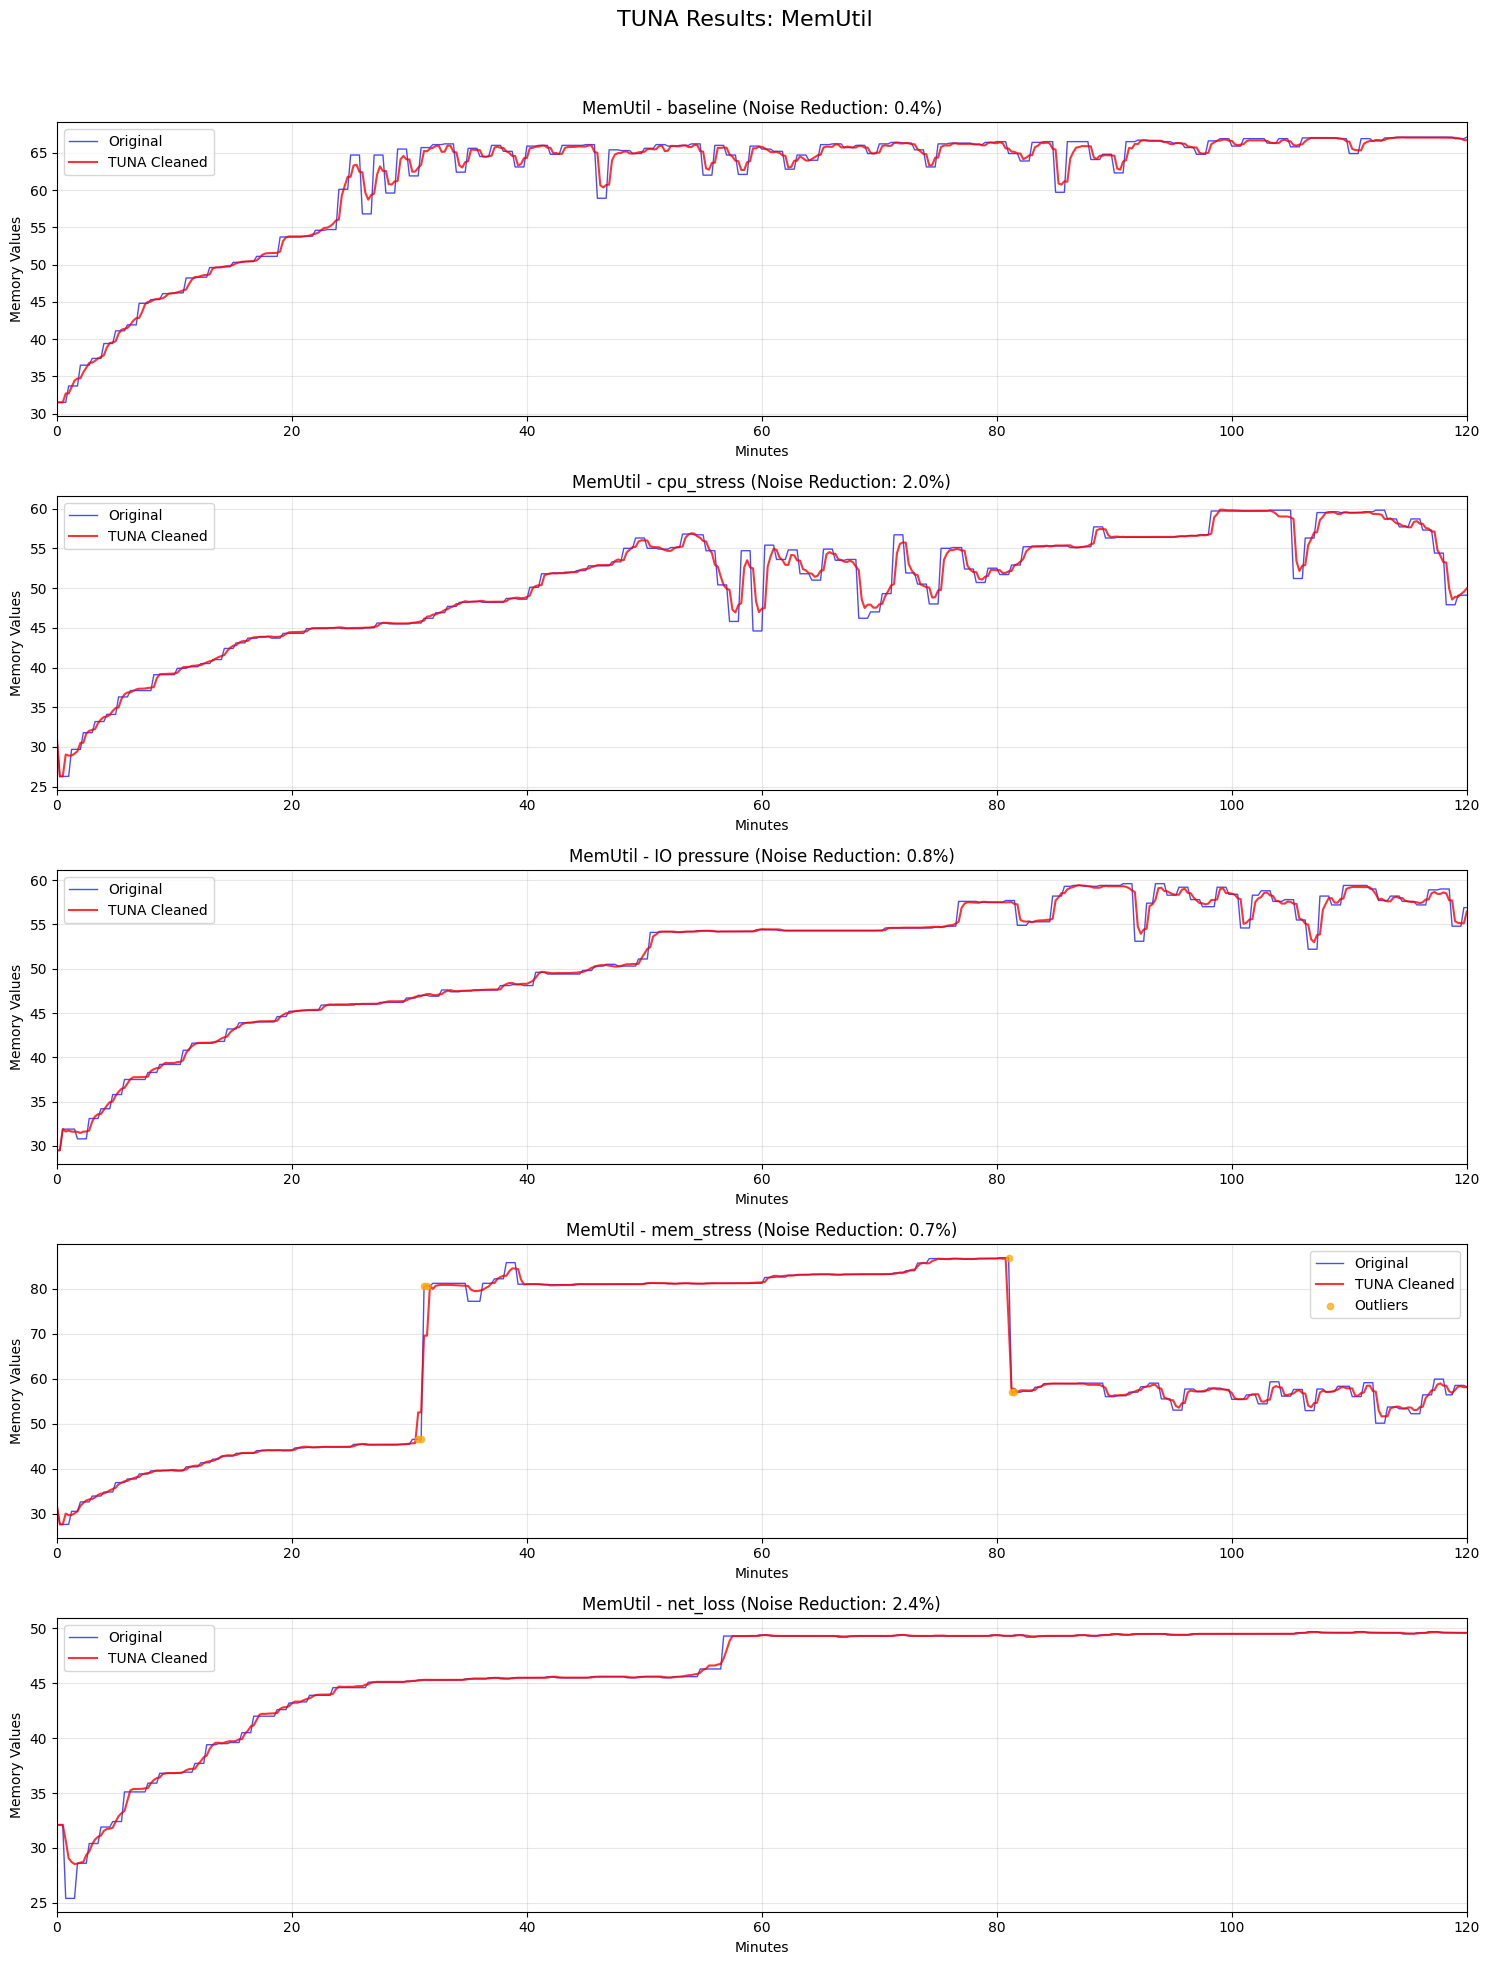

Created: cleaned_memory_data/baseline/memavailable_baseline.csv
Created: cleaned_memory_data/cpu_stress/memavailable_cpu_stress.csv
Created: cleaned_memory_data/IO pressure/memavailable_IO pressure.csv
Created: cleaned_memory_data/mem_stress/memavailable_mem_stress.csv
Created: cleaned_memory_data/net_loss/memavailable_net_loss.csv
Created: cleaned_memory_data/baseline/memcache_baseline.csv
Created: cleaned_memory_data/cpu_stress/memcache_cpu_stress.csv
Created: cleaned_memory_data/IO pressure/memcache_IO pressure.csv
Created: cleaned_memory_data/mem_stress/memcache_mem_stress.csv
Created: cleaned_memory_data/net_loss/memcache_net_loss.csv
Created: cleaned_memory_data/baseline/memutil_baseline.csv
Created: cleaned_memory_data/cpu_stress/memutil_cpu_stress.csv
Created: cleaned_memory_data/IO pressure/memutil_IO pressure.csv
Created: cleaned_memory_data/mem_stress/memutil_mem_stress.csv
Created: cleaned_memory_data/net_loss/memutil_net_loss.csv

Total files created: 15


In [3]:
def safe_convert_to_float(series):
    try:
        return pd.to_numeric(series, errors='coerce').fillna(0.0).astype(float)
    except:
        return series.fillna(0.0).astype(float)

def safe_array_conversion(data):
    data = np.array(data, dtype=float)
    if np.any(np.isnan(data)):
        median_val = np.nanmedian(data)
        if np.isnan(median_val):
            median_val = 0.0
        data = np.nan_to_num(data, nan=median_val)
    return data

def get_data_columns(df):
    """Get columns that contain actual data (excluding time/metadata columns)"""
    exclude_cols = ['Time', 'Minutes', 'source']
    return [col for col in df.columns if col not in exclude_cols]

def detect_outliers_tuna(timeseries, window_size=3, threshold=0.40, min_absolute_range=None):
    timeseries = safe_array_conversion(timeseries)
    outlier_mask = np.zeros(len(timeseries), dtype=bool)
    
    if min_absolute_range is None:
        std_val = np.std(timeseries)
        if std_val == 0 or np.isnan(std_val):
            min_absolute_range = 0.01 * np.max(timeseries)
        else:
            min_absolute_range = 0.1 * std_val
    
    if min_absolute_range <= 0:
        min_absolute_range = 1e-6
    
    for i in range(len(timeseries) - window_size + 1):
        window = timeseries[i:i + window_size]
        window_mean = np.mean(window)
        window_range = np.max(window) - np.min(window)
        
        if window_mean > 0 and window_range > 0:
            relative_range = window_range / window_mean
            
            if relative_range > threshold and window_range > min_absolute_range:
                window_max = np.max(window)
                window_min = np.min(window)
                
                for j in range(window_size):
                    actual_idx = i + j
                    if (timeseries[actual_idx] == window_max or 
                        timeseries[actual_idx] == window_min):
                        outlier_mask[actual_idx] = True
    
    return outlier_mask

def create_features_for_ml(timeseries, experiment_type, window_size=3):
    """Create features for RandomForest training - LEGACY VERSION"""
    timeseries = safe_array_conversion(timeseries)
    features = []
    
    for i in range(window_size, len(timeseries)):
        window = timeseries[i-window_size:i]
        
        feature_vector = [
            np.mean(window),
            np.std(window),
            np.median(window),
            np.max(window) - np.min(window),
            timeseries[i-1],
            i / len(timeseries),
        ]
        
        feature_vector = [0.0 if np.isnan(val) or np.isinf(val) else float(val) for val in feature_vector]
        
        exp_features = [0, 0, 0, 0, 0]
        if experiment_type == "baseline":
            exp_features[0] = 1
        elif experiment_type == "cpu_stress":
            exp_features[1] = 1
        elif experiment_type == "delay":
            exp_features[2] = 1
        elif experiment_type == "mem_stress":
            exp_features[3] = 1
        elif experiment_type == "net_loss":
            exp_features[4] = 1
        
        feature_vector.extend(exp_features)
        features.append(feature_vector)
    
    return np.array(features)

def create_features_for_ml_stable_only(timeseries, stable_mask, experiment_type, window_size=3):
    """
    Uses same window size as outlier detection for consistency
    """
    timeseries = safe_array_conversion(timeseries)
    features = []
    feature_indices = []
    
    for i in range(window_size, len(timeseries)):
        # Only create features if the current point is stable
        if stable_mask[i]:
            # Get the window and check if it's stable
            window = timeseries[i-window_size:i]
            window_stable_mask = stable_mask[i-window_size:i]
            
            # Use only stable values in the window for feature calculation
            stable_window = window[window_stable_mask]
            
            if len(stable_window) > 0:
                feature_vector = [
                    np.mean(stable_window),
                    np.std(stable_window),
                    np.median(stable_window),
                    np.max(stable_window) - np.min(stable_window),
                    timeseries[i-1] if stable_mask[i-1] else np.mean(stable_window),
                    i / len(timeseries),
                ]
                
                # Clean any NaN/inf values
                feature_vector = [0.0 if np.isnan(val) or np.isinf(val) else float(val) for val in feature_vector]
                
                # Experiment context encoding
                exp_features = [0, 0, 0, 0, 0]
                if experiment_type == "baseline":
                    exp_features[0] = 1
                elif experiment_type == "cpu_stress":
                    exp_features[1] = 1
                elif experiment_type == "delay":
                    exp_features[2] = 1
                elif experiment_type == "mem_stress":
                    exp_features[3] = 1
                elif experiment_type == "net_loss":
                    exp_features[4] = 1
                
                feature_vector.extend(exp_features)
                features.append(feature_vector)
                feature_indices.append(i)
    
    return np.array(features), np.array(feature_indices)

def train_models_for_all_columns(metric_name, all_experiments):
    """
    FIXED: Train separate RandomForest models for each column using ONLY stable periods
    """
    
    exclude_cols = ['Time', 'Minutes', 'source']
    first_df = list(all_experiments.values())[0]
    value_cols = [col for col in first_df.columns if col not in exclude_cols]
    
    models = {}
    scalers = {}
    
    WINDOW_SIZE = 3
    
    for col in value_cols:
        X_stable_all = []
        y_stable_all = []
        
        for exp_name, df in all_experiments.items():
            col_values = safe_convert_to_float(df[col]).values
            col_values = safe_array_conversion(col_values)
            
            outlier_mask = detect_outliers_tuna(col_values, window_size=WINDOW_SIZE)
            stable_mask = ~outlier_mask
            
            # FIXED: Use stable-only feature creation with consistent window size
            features, feature_indices = create_features_for_ml_stable_only(
                col_values, stable_mask, exp_name, window_size=WINDOW_SIZE
            )
            
            if len(features) > 0:
                # Get targets for the corresponding stable feature indices
                stable_targets = col_values[feature_indices]
                
                # All targets should be stable by construction, but double-check
                valid_mask = ~(np.isnan(stable_targets) | np.isinf(stable_targets))
                stable_features = features[valid_mask]
                stable_targets = stable_targets[valid_mask]
                
                if len(stable_features) > 0:
                    # Apply local smoothing to targets
                    smoothed_targets = []
                    for j, target in enumerate(stable_targets):
                        start_idx = max(0, j-2)
                        end_idx = min(len(stable_targets), j+3)
                        local_values = stable_targets[start_idx:end_idx]
                        smoothed_targets.append(np.median(local_values))
                    
                    X_stable_all.extend(stable_features)
                    y_stable_all.extend(smoothed_targets)
        
        # Train model for this column if we have enough stable data
        if len(X_stable_all) >= 10:
            X_stable_all = np.array(X_stable_all)
            y_stable_all = np.array(y_stable_all)
            
            # Clean any remaining NaN/inf values
            nan_mask = np.isnan(y_stable_all) | np.isinf(y_stable_all)
            if np.any(nan_mask):
                X_stable_all = X_stable_all[~nan_mask]
                y_stable_all = y_stable_all[~nan_mask]
            
            feature_nan_mask = np.isnan(X_stable_all).any(axis=1) | np.isinf(X_stable_all).any(axis=1)
            if np.any(feature_nan_mask):
                X_stable_all = X_stable_all[~feature_nan_mask]
                y_stable_all = y_stable_all[~feature_nan_mask]
            
            if len(X_stable_all) >= 10:
                try:
                    scaler = StandardScaler()
                    X_scaled = scaler.fit_transform(X_stable_all)
                    
                    param_grid = {
                        'n_estimators': [100],
                        'max_depth': [5, 10, 15],
                        'min_samples_split': [2, 5],
                        'min_samples_leaf': [1, 2, 4],
                        'max_features': ['sqrt', 'log2']
                    }
                    
                    model = RandomForestRegressor(
                        criterion='squared_error',
                        bootstrap=True,
                        n_jobs=-1,
                        random_state=42
                    )
                    
                    grid_search = GridSearchCV(
                        estimator=model,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error',
                        cv=3,
                        n_jobs=-1,
                        verbose=0
                    )
                    
                    grid_search.fit(X_scaled, y_stable_all)
                    
                    models[col] = grid_search.best_estimator_
                    scalers[col] = scaler
                    
                except Exception:
                    models[col] = None
                    scalers[col] = None
            else:
                models[col] = None
                scalers[col] = None
        else:
            models[col] = None
            scalers[col] = None
    
    return models, scalers

def apply_penalty(timeseries, outlier_mask, penalty_factor=0.5):
    timeseries = safe_array_conversion(timeseries)
    cleaned_series = timeseries.copy()
    
    stable_values = timeseries[~outlier_mask]
    if len(stable_values) > 0:
        baseline = np.median(stable_values)
    else:
        baseline = np.median(timeseries)
    
    if np.isnan(baseline):
        baseline = 0.0
    
    for i in range(len(timeseries)):
        if outlier_mask[i]:
            original_value = timeseries[i]
            if np.isnan(original_value):
                cleaned_series[i] = baseline
            else:
                cleaned_series[i] = baseline + (original_value - baseline) * penalty_factor
    
    return cleaned_series

def apply_tuna_to_single_series(column_values, exp_name, model, scaler, penalty_factor=0.5, blend_weight=1):
    """
    Apply TUNA cleaning to a single time series
    """
    column_values = safe_array_conversion(column_values)
    
    # Use same window size as training
    WINDOW_SIZE = 3
    
    # Phase 1: Identify unstable measurements
    outlier_mask = detect_outliers_tuna(column_values, window_size=WINDOW_SIZE)
    stable_mask = ~outlier_mask
    outliers_count = np.sum(outlier_mask)
    
    # Phase 2: Apply penalty to unstable measurements
    cleaned_series = apply_penalty(column_values, outlier_mask, penalty_factor)
    
    # Phase 3: Enhance stable regions with ML predictions
    if model is not None and scaler is not None:
        try:
            # Create features using stable-only approach with consistent window size
            features, feature_indices = create_features_for_ml_stable_only(
                column_values, stable_mask, exp_name, window_size=WINDOW_SIZE
            )
            
            if len(features) > 0:
                features_scaled = scaler.transform(features)
                ml_predictions = model.predict(features_scaled)
                
                # Apply predictions to stable regions only
                for i, prediction in enumerate(ml_predictions):
                    actual_idx = feature_indices[i]
                    if actual_idx < len(cleaned_series) and stable_mask[actual_idx]:
                        if not np.isnan(prediction) and not np.isinf(prediction):
                            original_value = column_values[actual_idx]
                            cleaned_series[actual_idx] = (
                                blend_weight * prediction + 
                                (1 - blend_weight) * original_value
                            )
        except Exception:
            pass
    
    original_std = np.std(column_values)
    cleaned_std = np.std(cleaned_series)
    
    if original_std > 0 and not np.isnan(original_std):
        noise_reduction = (original_std - cleaned_std) / original_std * 100
    else:
        noise_reduction = 0.0
    
    if len(column_values) > 1:
        correlation = np.corrcoef(column_values, cleaned_series)[0, 1]
        if np.isnan(correlation):
            correlation = 1.0
    else:
        correlation = 1.0
    
    cleaning_stats = {
        'outliers': outliers_count,
        'outlier_percentage': (outliers_count / len(column_values)) * 100,
        'noise_reduction': noise_reduction,
        'correlation': correlation
    }
    
    return cleaned_series, outlier_mask, cleaning_stats

def apply_tuna_to_each_column(df, exp_name, models, scalers, penalty_factor=0.5, blend_weight=1):
    """Apply TUNA cleaning to each column individually"""
    
    exclude_cols = ['Time', 'Minutes', 'source']
    value_cols = [col for col in df.columns if col not in exclude_cols]
    
    column_results = {}
    cleaned_df = df.copy()
    
    for col in value_cols:
        col_values = safe_convert_to_float(df[col]).values
        model = models.get(col)
        scaler = scalers.get(col)
        
        cleaned_values, outlier_mask, stats = apply_tuna_to_single_series(
            col_values, exp_name, model, scaler, penalty_factor, blend_weight
        )
        
        column_results[col] = {
            'original': col_values,
            'cleaned': cleaned_values,
            'outliers': outlier_mask,
            'stats': stats
        }
        
        cleaned_df[col] = cleaned_values
    
    return cleaned_df, column_results

def run_tuna_for_all_metrics_by_column(all_datasets):
    """Run TUNA for all metrics, processing each column individually"""    
    tuna_results = {}
    
    for metric_name, experiments in all_datasets.items():
        models, scalers = train_models_for_all_columns(metric_name, experiments)
        
        metric_results = {}
        for exp_name, df in experiments.items():
            cleaned_df, column_results = apply_tuna_to_each_column(
                df, exp_name, models, scalers
            )
            
            total_outliers = sum(result['stats']['outliers'] for result in column_results.values())
            
            exclude_cols = ['Time', 'Minutes', 'source']
            value_cols = [col for col in df.columns if col not in exclude_cols]
            
            # Calculate overall stats
            avg_noise_reduction = sum(result['stats']['noise_reduction'] for result in column_results.values()) / len(column_results) if column_results else 0
            avg_correlation = sum(result['stats']['correlation'] for result in column_results.values()) / len(column_results) if column_results else 1
            
            metric_results[exp_name] = {
                'column_results': column_results,
                'stats': {
                    'outliers': total_outliers,
                    'noise_reduction': avg_noise_reduction,
                    'correlation': avg_correlation
                }
            }
        
        tuna_results[metric_name] = metric_results
    
    return tuna_results

def plot_tuna_results_column_by_column(tuna_results, all_datasets):
    """Plot results for column-by-column processing"""
    for metric_name, metric_results in tuna_results.items():
        n_experiments = len(metric_results)
        fig, axes = plt.subplots(n_experiments, 1, figsize=(15, 4*n_experiments))
        
        if n_experiments == 1:
            axes = [axes]
        
        for i, (exp_name, results) in enumerate(metric_results.items()):
            df = all_datasets[metric_name][exp_name]
            minutes = df['Minutes'].values
            
            column_results = results['column_results']
            
            if len(column_results) == 1:
                # Single column - plot directly
                col_name = list(column_results.keys())[0]
                col_results = column_results[col_name]
                original = col_results['original']
                cleaned = col_results['cleaned']
                outliers = col_results['outliers']
                stats = col_results['stats']
            else:
                # Multiple columns - take the first column as representative
                col_name = list(column_results.keys())[0]
                col_results = column_results[col_name]
                original = col_results['original']
                cleaned = col_results['cleaned']
                outliers = col_results['outliers']
                stats = results['stats']  # Use overall stats for multiple columns
            
            axes[i].plot(minutes, original, 'b-', alpha=0.7, label='Original', linewidth=1)
            axes[i].plot(minutes, cleaned, 'r-', alpha=0.8, label='TUNA Cleaned', linewidth=1.5)
            
            outlier_points = np.where(outliers)[0]
            if len(outlier_points) > 0:
                axes[i].scatter(minutes[outlier_points], original[outlier_points], 
                               c='orange', s=20, alpha=0.7, label='Outliers', zorder=5)
            
            # Determine y-label based on metric type
            if 'srtt' in metric_name.lower():
                y_label = 'SRTT Values'
            elif any(service in metric_name.lower() for service in ['apigateway', 'customers', 'visits', 'vets']):
                y_label = 'Retransmission Packets'
            elif 'mem' in metric_name.lower():
                y_label = 'Memory Values'
            else:
                y_label = 'Values'
            
            axes[i].set_title(f'{metric_name} - {exp_name} (Noise Reduction: {stats["noise_reduction"]:.1f}%)')
            axes[i].set_xlabel('Minutes')
            axes[i].set_ylabel(y_label)
            axes[i].set_xlim(0, 120) 
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
        
        plt.suptitle(f'TUNA Results: {metric_name}', fontsize=16, y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

def print_tuna_summary_column_by_column(tuna_results):
    """Print summary for column-by-column processing"""
    pass

def create_cleaned_csv_from_tuna_columns(original_df, column_results, metric_name, experiment_name, include_metadata=False):
    """Create cleaned CSV from column-by-column results"""
    cleaned_df = original_df.copy()
    
    # Replace each column with its cleaned version
    for col, col_results in column_results.items():
        if col in cleaned_df.columns:
            cleaned_series = col_results['cleaned']
            cleaned_df[col] = cleaned_series[:len(cleaned_df)]
    
    if include_metadata:
        # Add overall metadata
        total_outliers = sum(col_results['stats']['outliers'] for col_results in column_results.values())
        avg_noise_reduction = sum(col_results['stats']['noise_reduction'] for col_results in column_results.values()) / len(column_results)
        avg_correlation = sum(col_results['stats']['correlation'] for col_results in column_results.values()) / len(column_results)
        
        cleaned_df['tuna_processed'] = True
        cleaned_df['tuna_total_outliers'] = total_outliers
        cleaned_df['tuna_avg_noise_reduction'] = avg_noise_reduction
        cleaned_df['tuna_avg_correlation'] = avg_correlation
        cleaned_df['tuna_metric_name'] = metric_name
        cleaned_df['tuna_experiment'] = experiment_name
        
        # Add column-specific metadata
        for col, col_results in column_results.items():
            stats = col_results['stats']
            outlier_mask = col_results['outliers']
            cleaned_df[f'tuna_{col}_outliers'] = stats['outliers']
            cleaned_df[f'tuna_{col}_noise_reduction'] = stats['noise_reduction']
            cleaned_df[f'tuna_{col}_correlation'] = stats['correlation']
            cleaned_df[f'tuna_{col}_outlier_flag'] = outlier_mask[:len(cleaned_df)]
    
    return cleaned_df

def export_all_cleaned_csvs(tuna_results, all_datasets, output_base_path="cleaned_memory_data", include_metadata=False, preserve_structure=True):
    """Export all TUNA-cleaned datasets organized by experiment type"""
    output_base = Path(output_base_path)
    output_base.mkdir(parents=True, exist_ok=True)
    
    created_files = {}
    total_files = 0
    
    # Get all experiment types from all metrics
    experiment_types = set()
    for metric_results in tuna_results.values():
        experiment_types.update(metric_results.keys())
    
    # Create directory structure by experiment type
    for exp_name in experiment_types:
        exp_dir = output_base / exp_name
        exp_dir.mkdir(exist_ok=True)
        created_files[exp_name] = []
    
    # Process each metric and experiment
    for metric_name, metric_results in tuna_results.items():
        for exp_name, results in metric_results.items():
            # Get original dataframe and column results
            original_df = all_datasets[metric_name][exp_name]
            column_results = results['column_results']
            
            # Create cleaned dataframe
            cleaned_df = create_cleaned_csv_from_tuna_columns(
                original_df=original_df,
                column_results=column_results,
                metric_name=metric_name,
                experiment_name=exp_name,
                include_metadata=include_metadata
            )
            
            csv_filename = f"{metric_name.lower()}_{exp_name}.csv"
            csv_path = output_base / exp_name / csv_filename
            
            # Export to CSV
            cleaned_df.to_csv(csv_path, index=False)
            created_files[exp_name].append(str(csv_path))
            total_files += 1
            
            print(f"Created: {csv_path}")
    
    print(f"\nTotal files created: {total_files}")
    return created_files

def export_tuna_data_to_csv(tuna_results, export_dir="../../noise_reduction_data"):    
    export_data = []
    
    for metric_name, metric_data in tuna_results.items():
        for experiment_name, experiment_data in metric_data.items():
            if 'stats' in experiment_data:
                stats = experiment_data['stats']
                
                export_data.append({
                    'experiment_name': experiment_name,
                    'metric': metric_name,
                    'noise_reduction_pct': stats.get('noise_reduction', 0.0),
                    'correlation': stats.get('correlation', 1.0),
                    'outliers_removed': stats.get('outliers', 0),
                })
    
    csv_filename = f"customers_tuna_memory.csv"
    csv_path = os.path.join(export_dir, csv_filename)
    
    df_simple = pd.DataFrame(export_data)
    df_simple.to_csv(csv_path, index=False)

    return csv_path

def main(all_datasets):    
    tuna_results = run_tuna_for_all_metrics_by_column(all_datasets)
    csv_path = export_tuna_data_to_csv(tuna_results)
    plot_tuna_results_column_by_column(tuna_results, all_datasets)
    print_tuna_summary_column_by_column(tuna_results)
    
    created_files = export_all_cleaned_csvs(
        tuna_results=tuna_results,
        all_datasets=all_datasets,
        output_base_path="cleaned_memory_data",
        include_metadata=False
    )
    
    return tuna_results

if __name__ == "__main__":
    tuna_results = main(all_datasets)

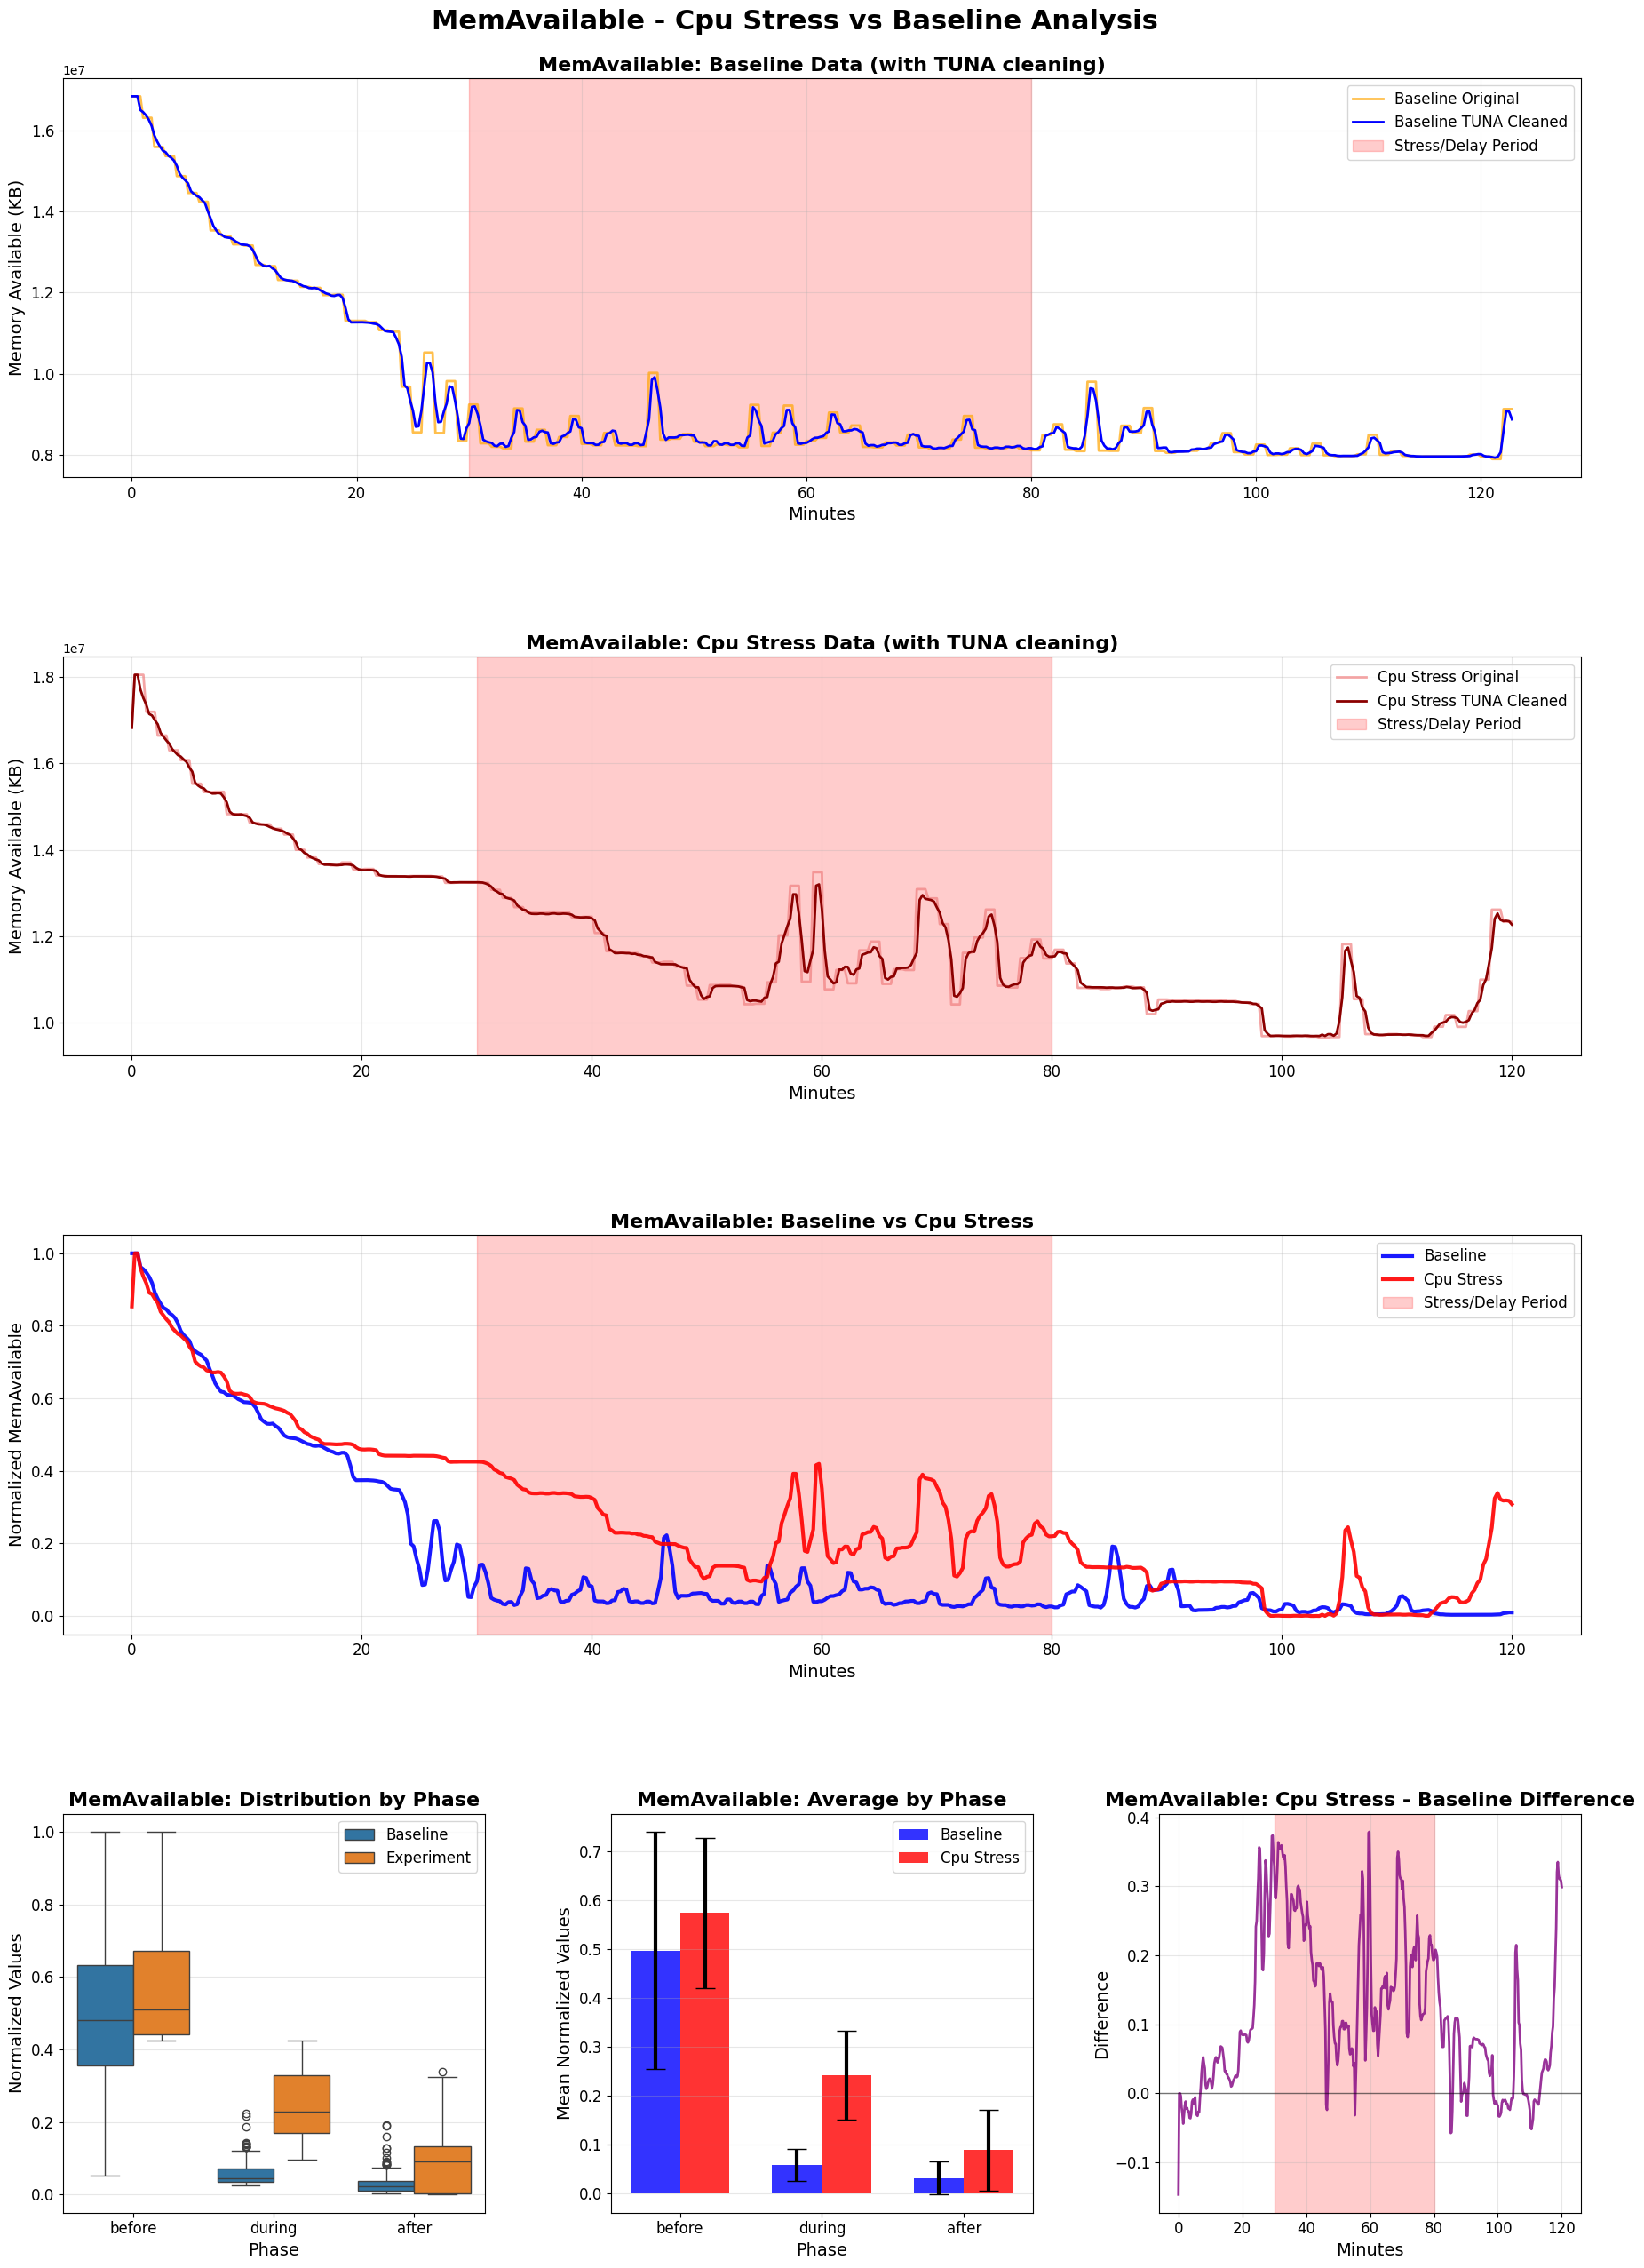

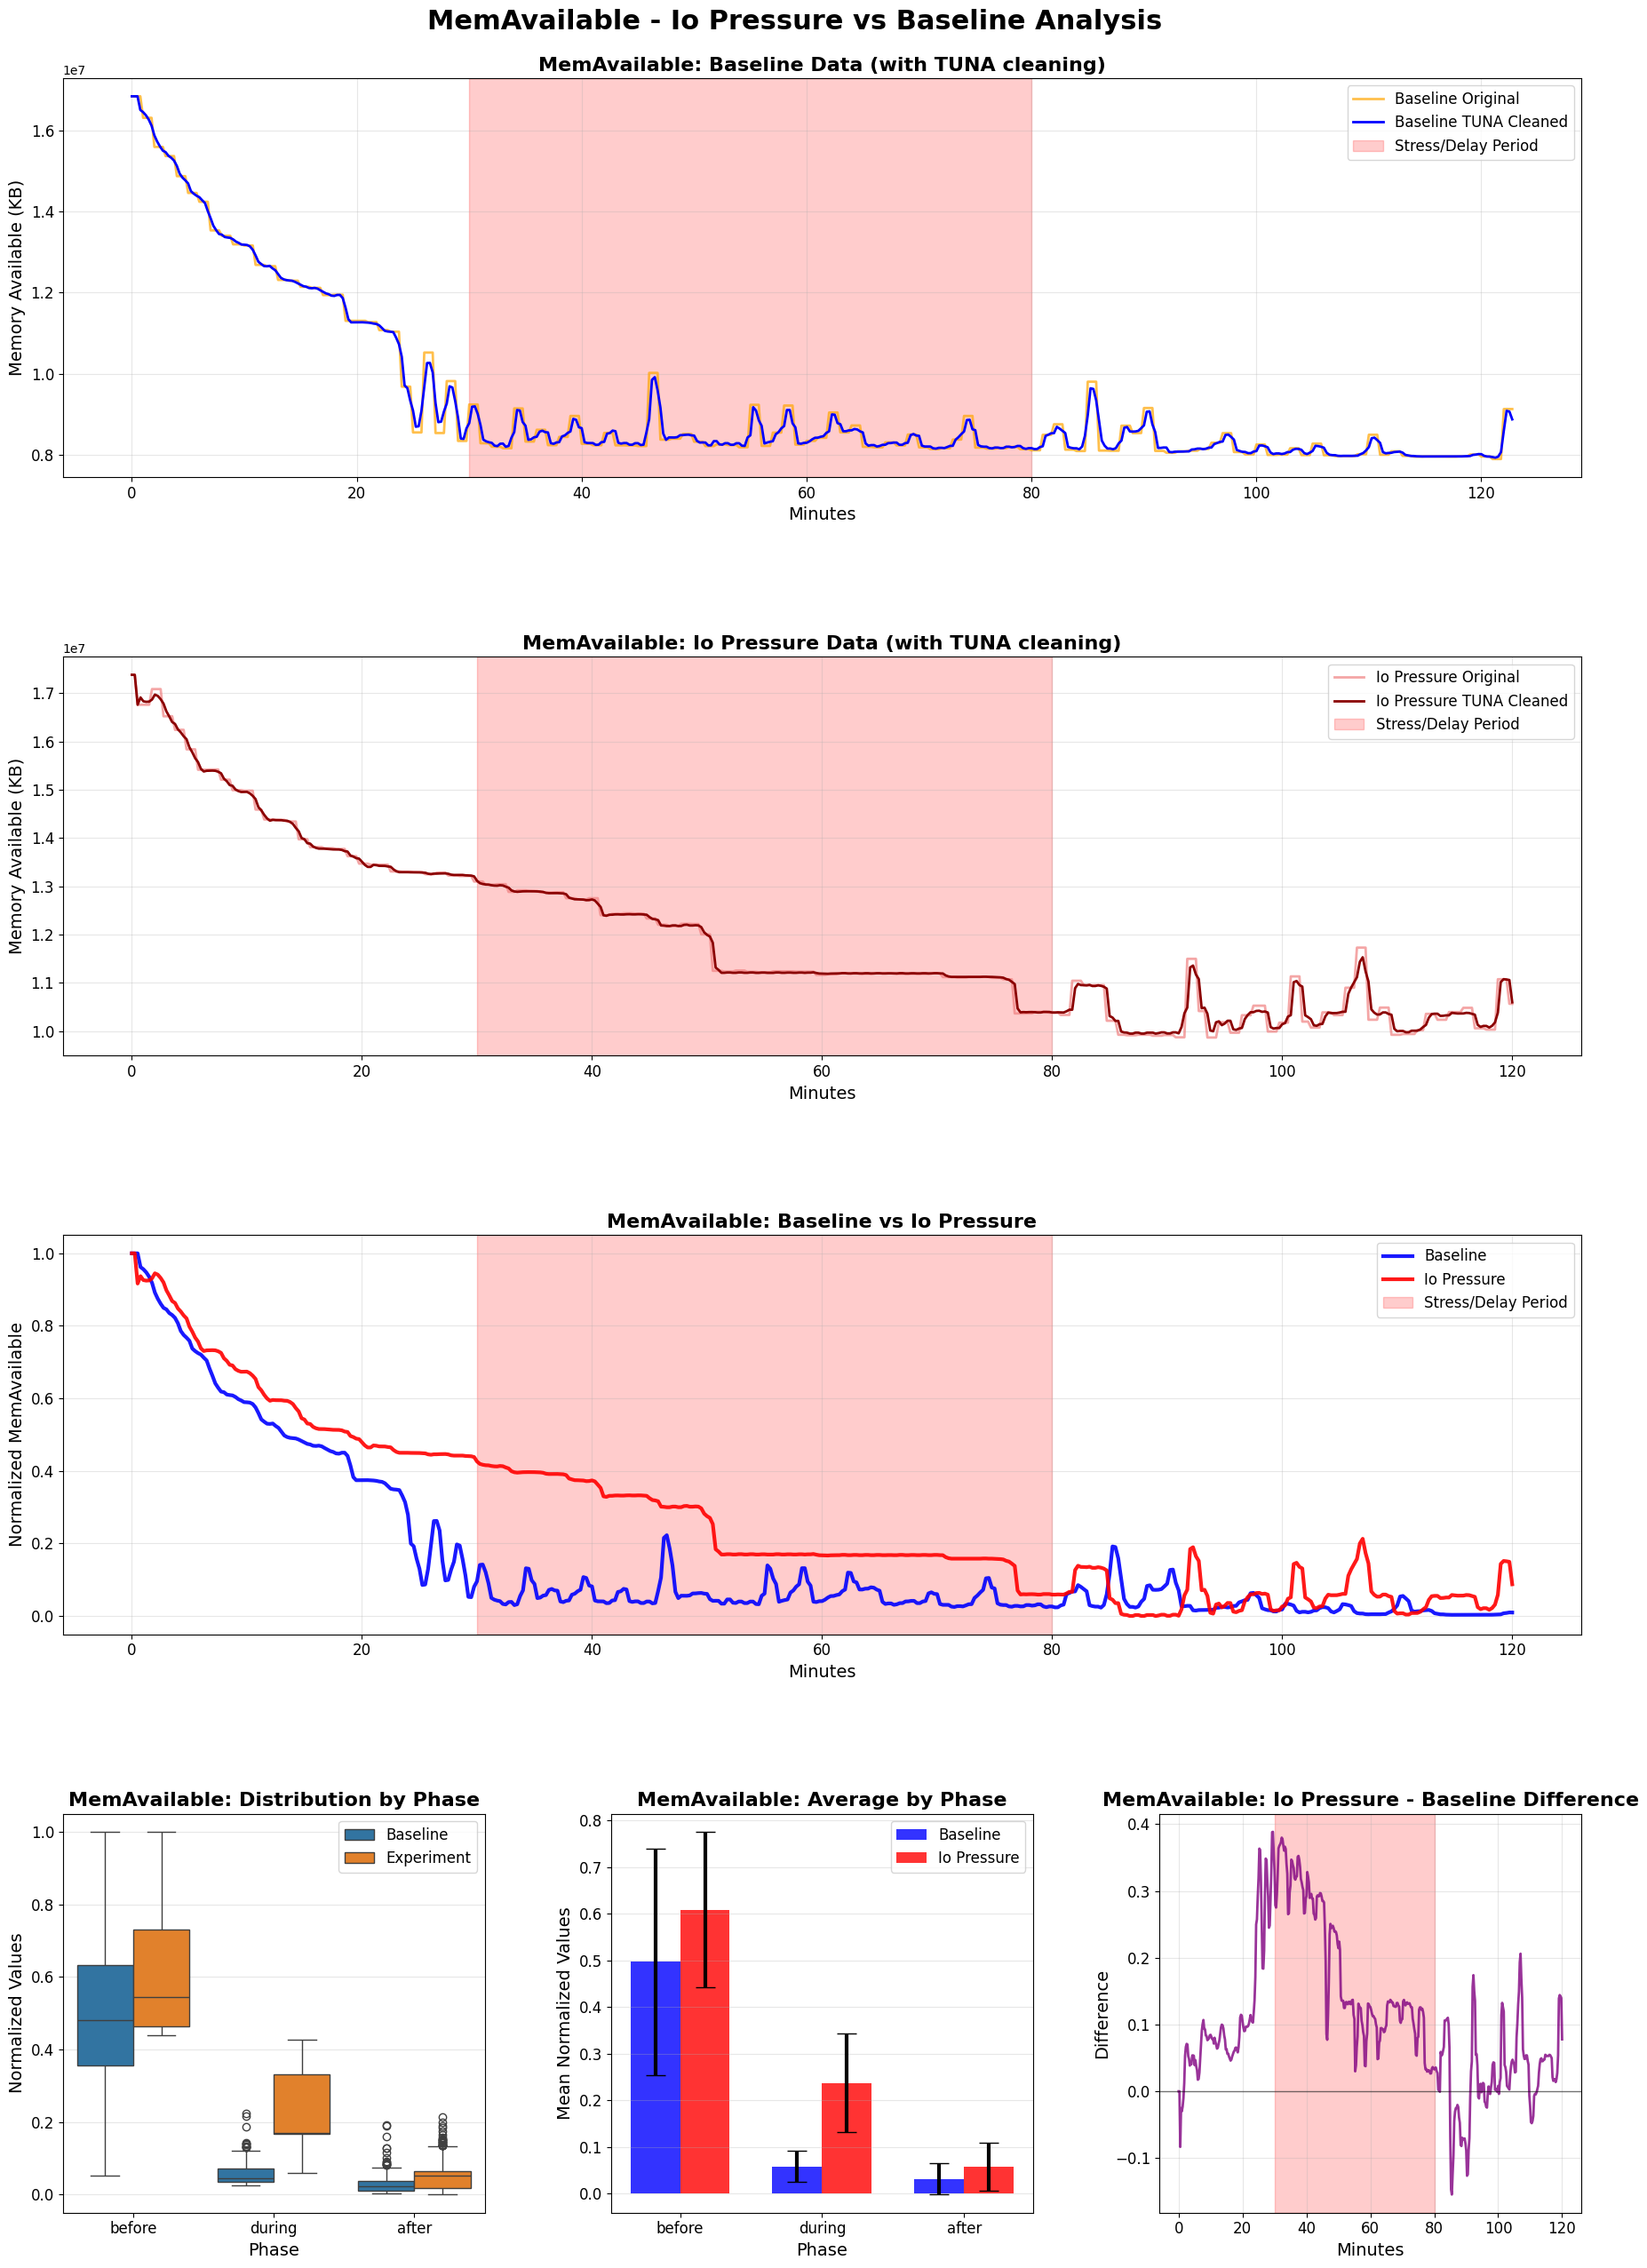

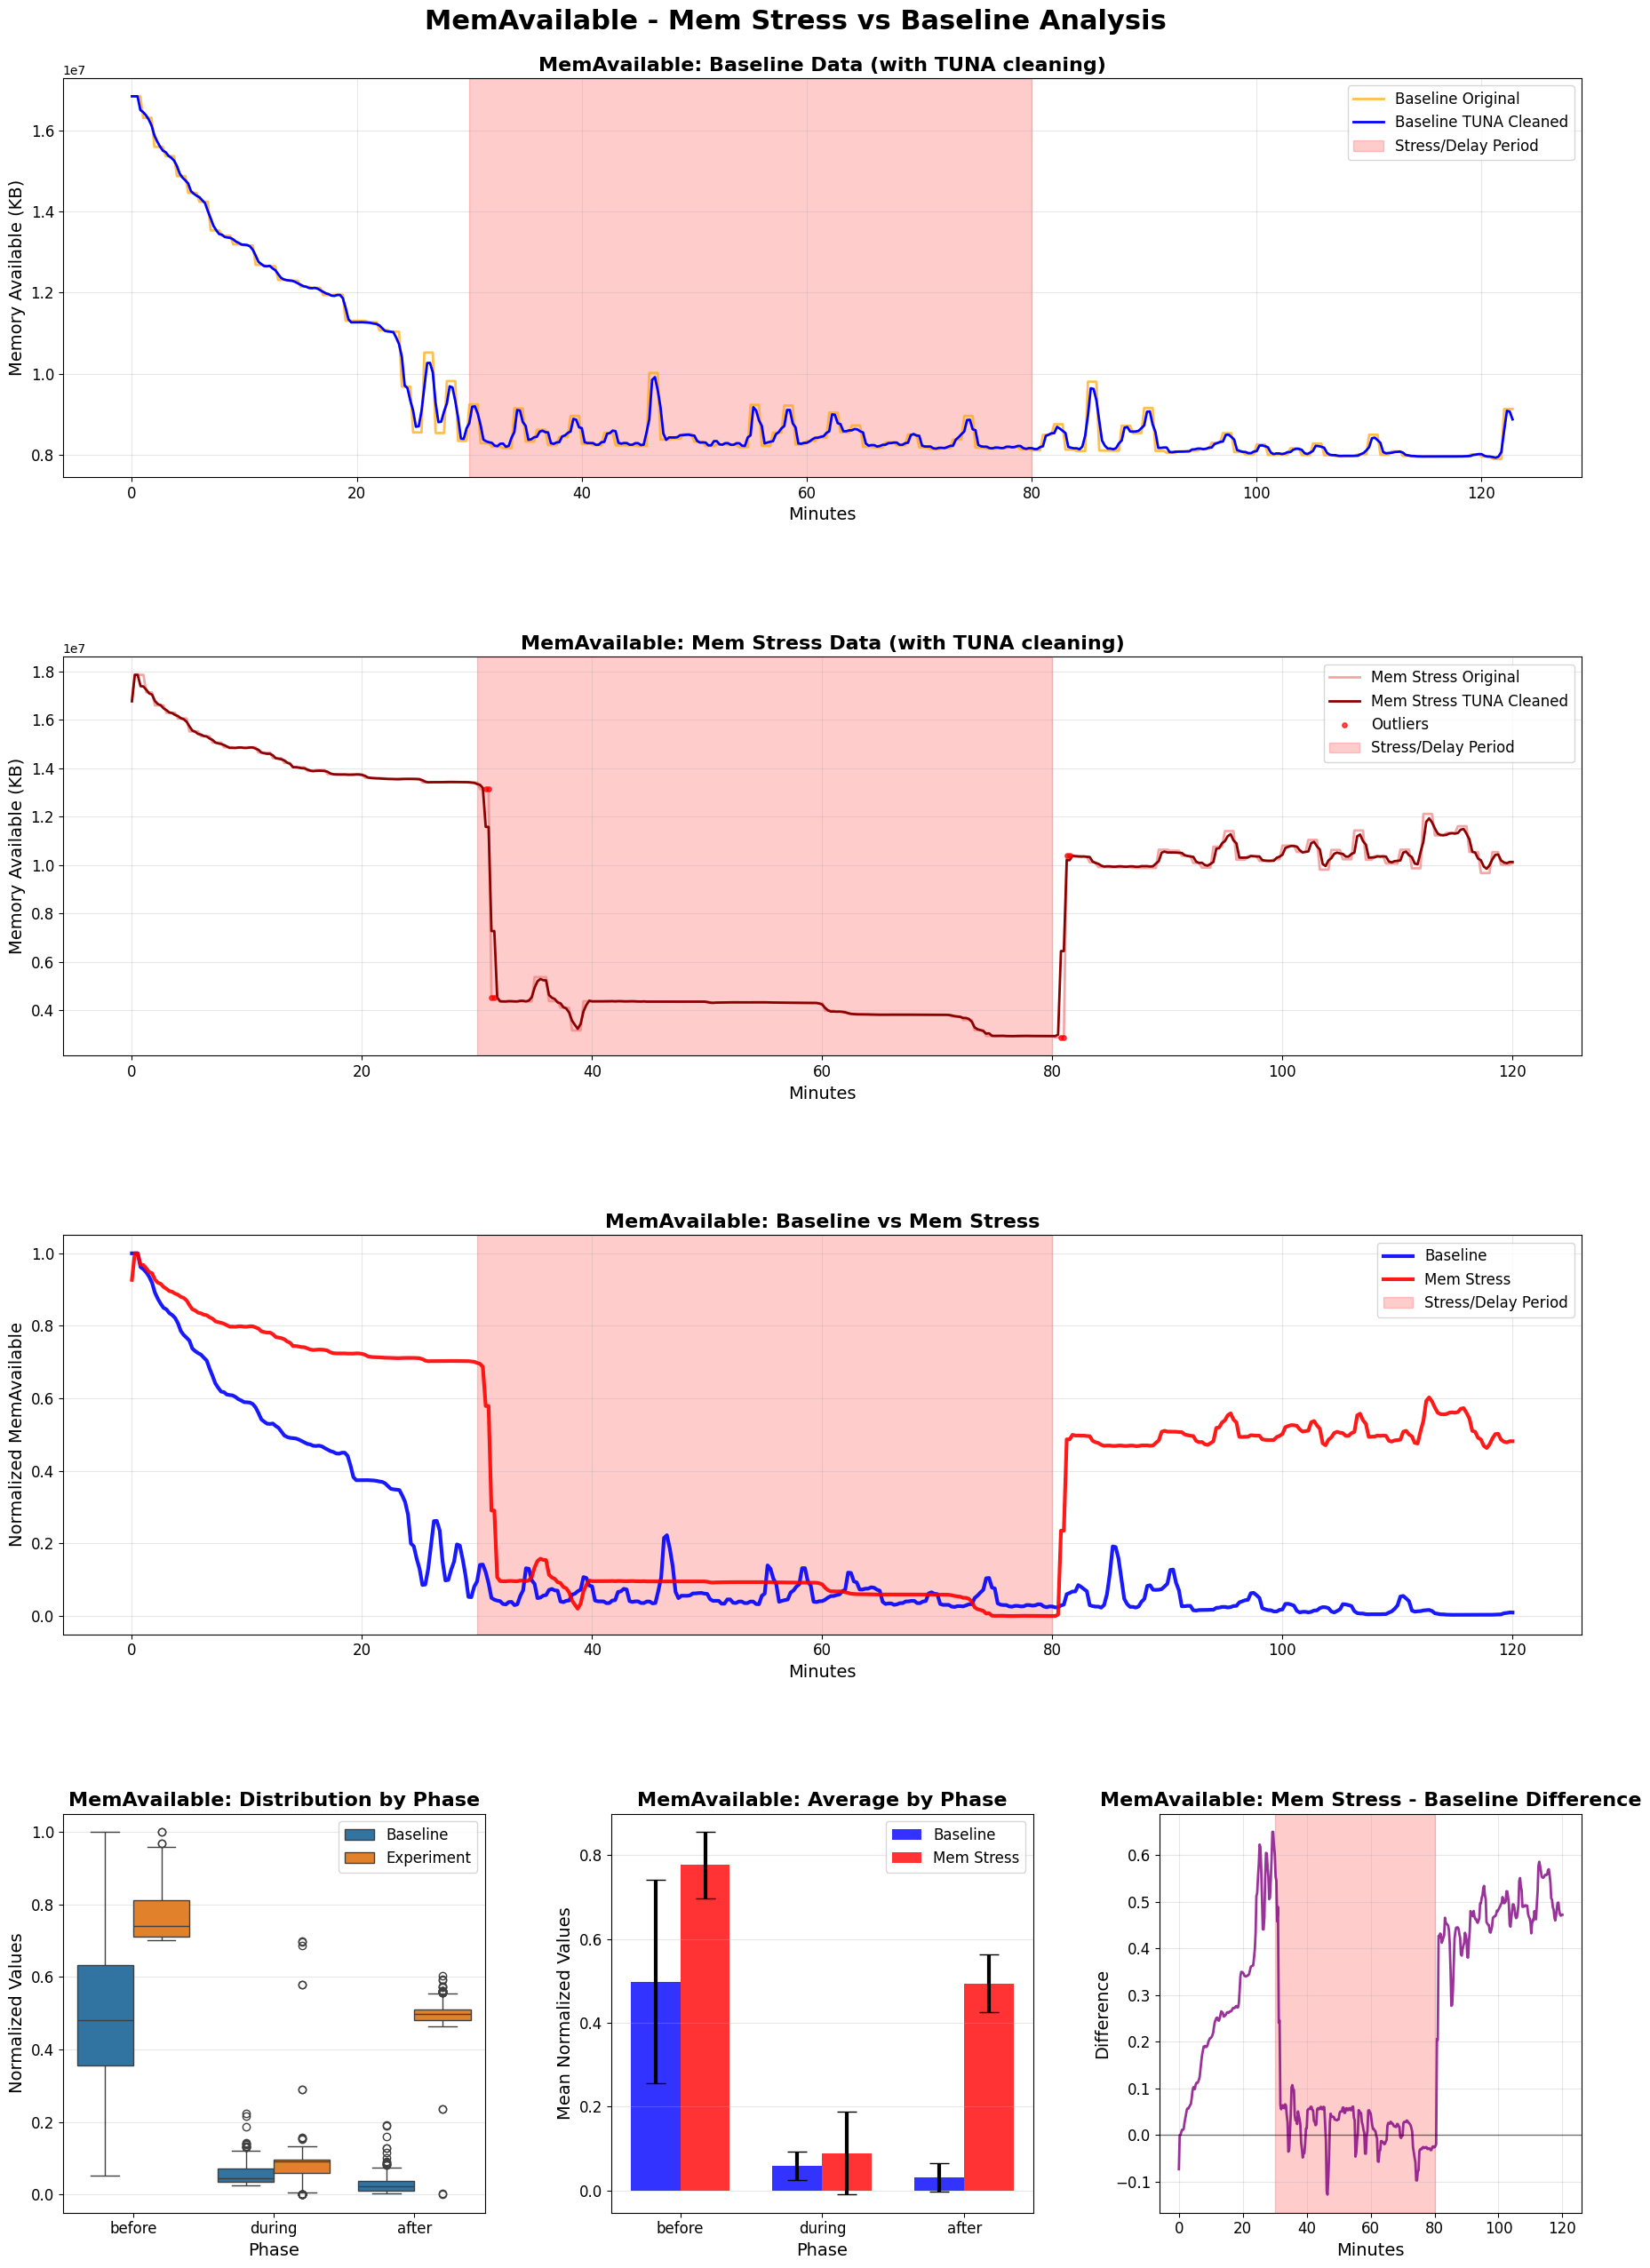

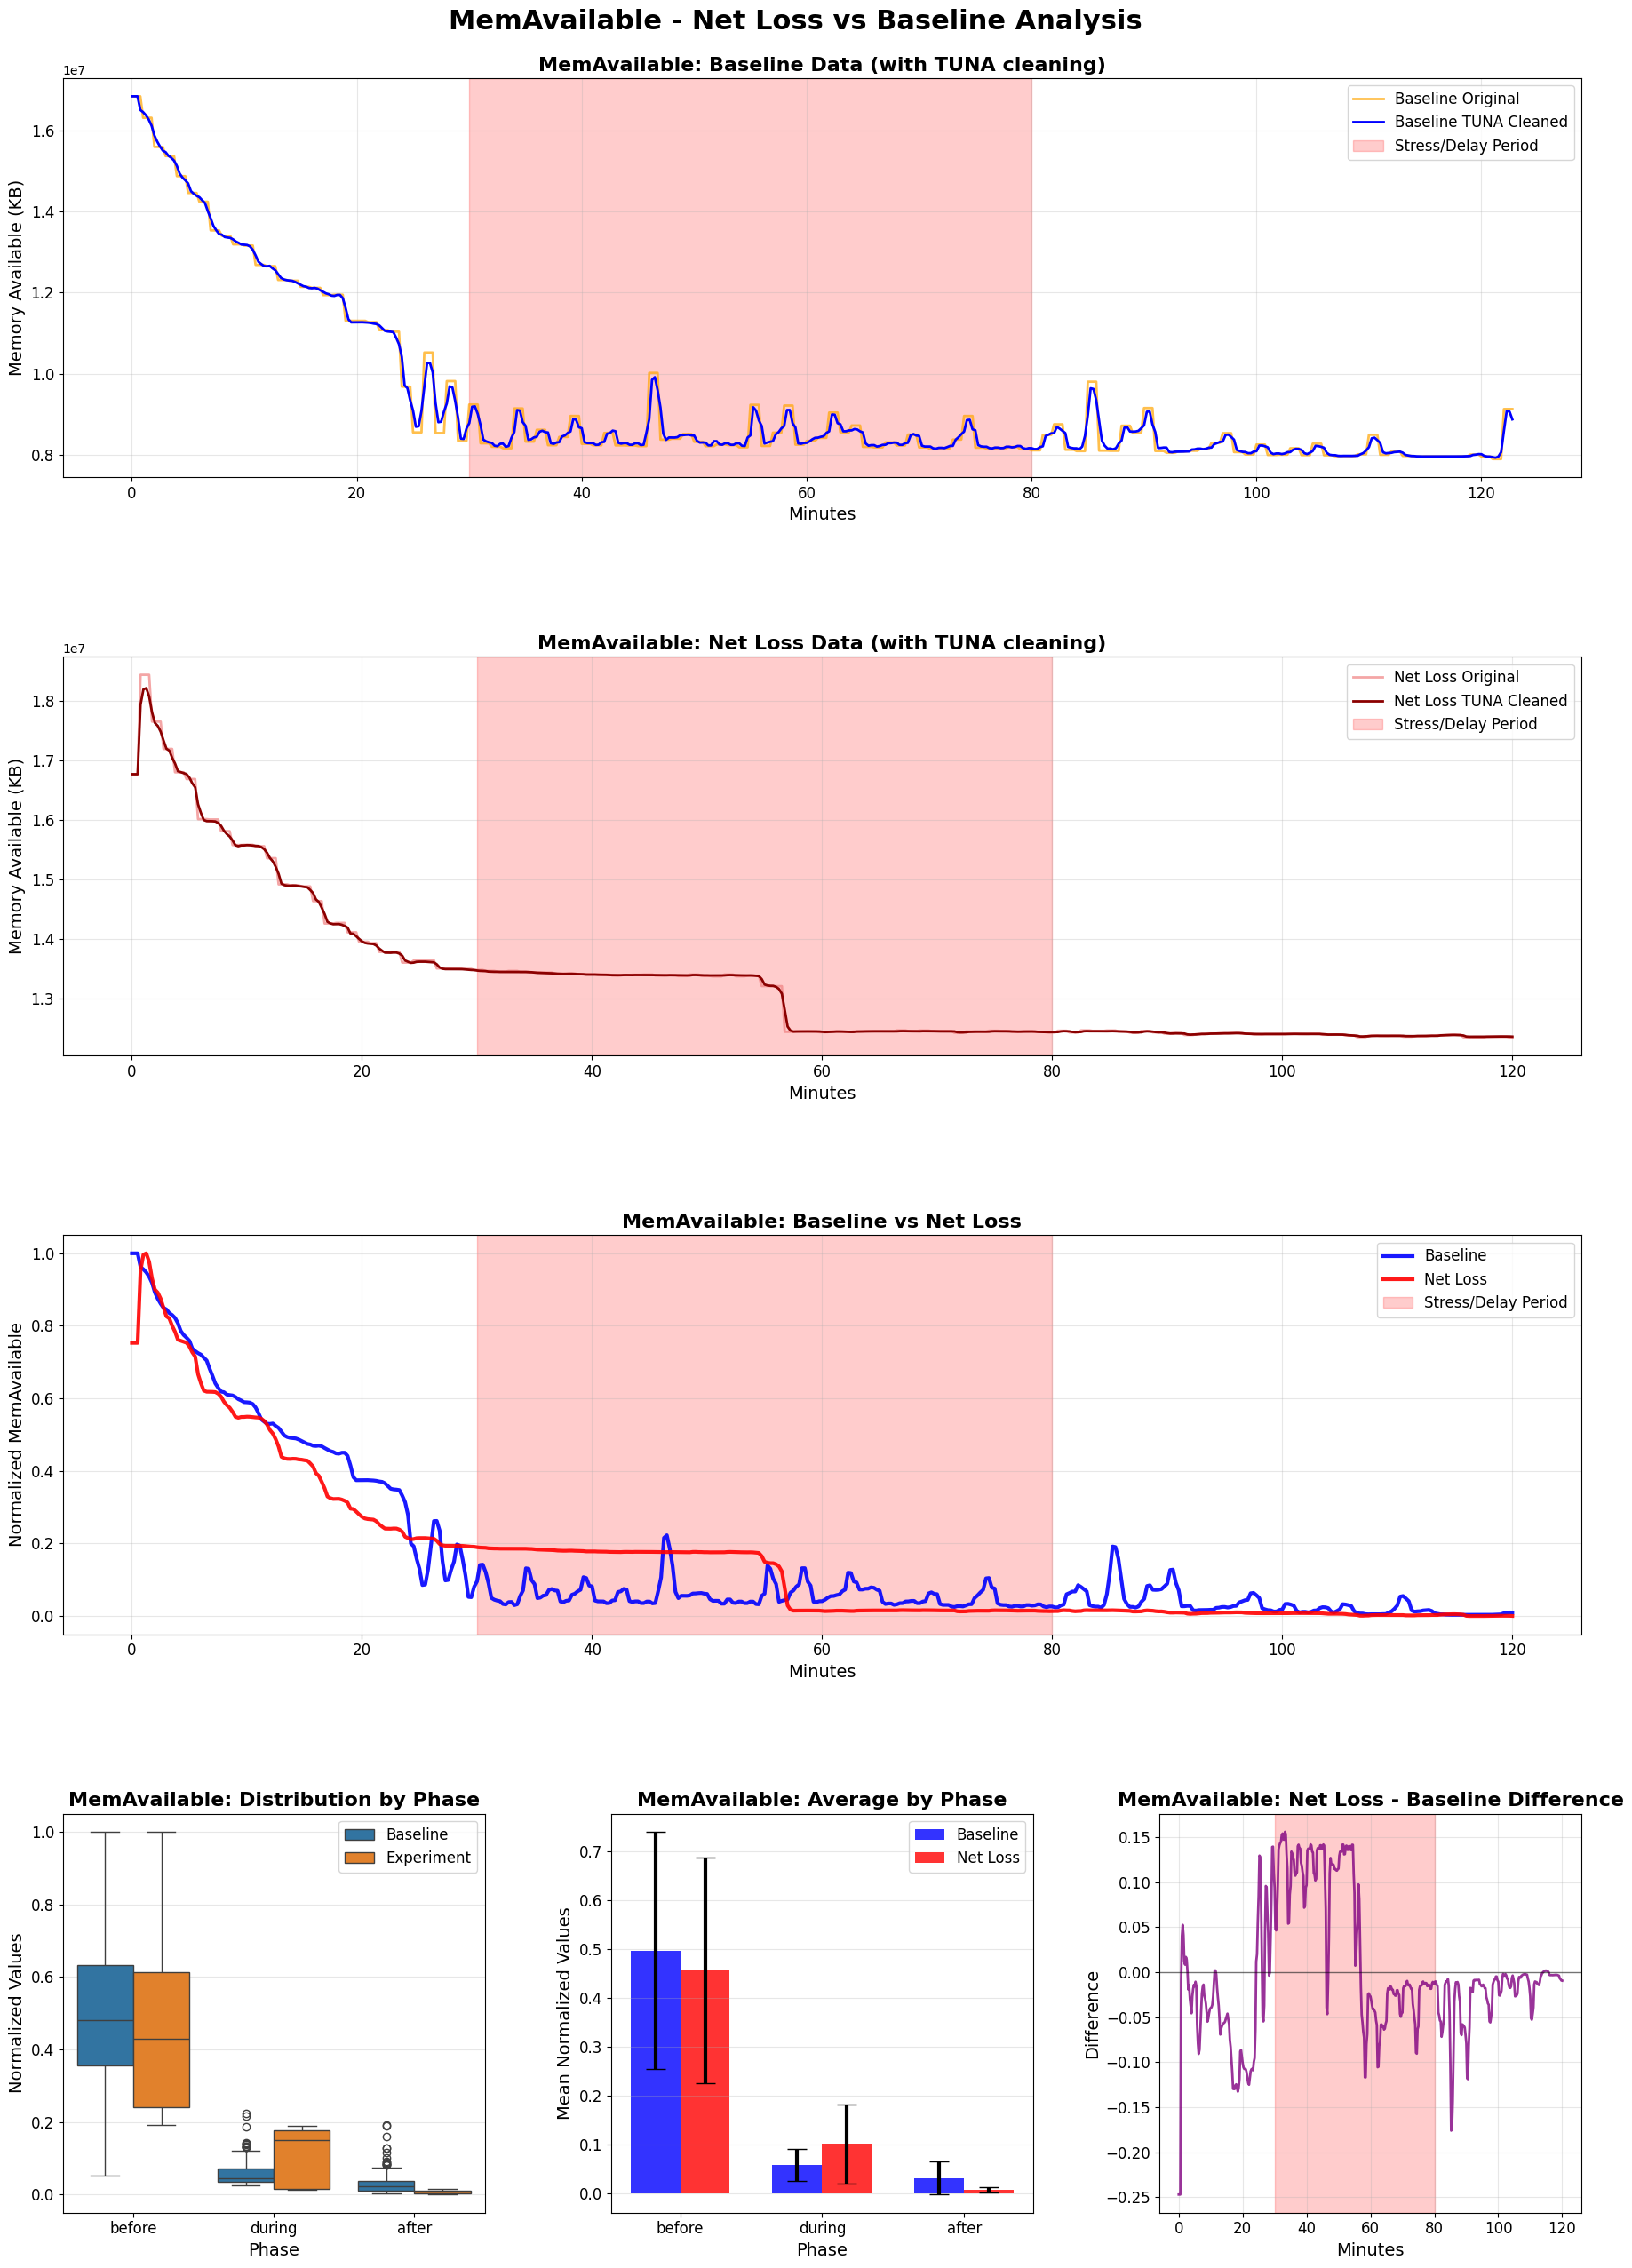

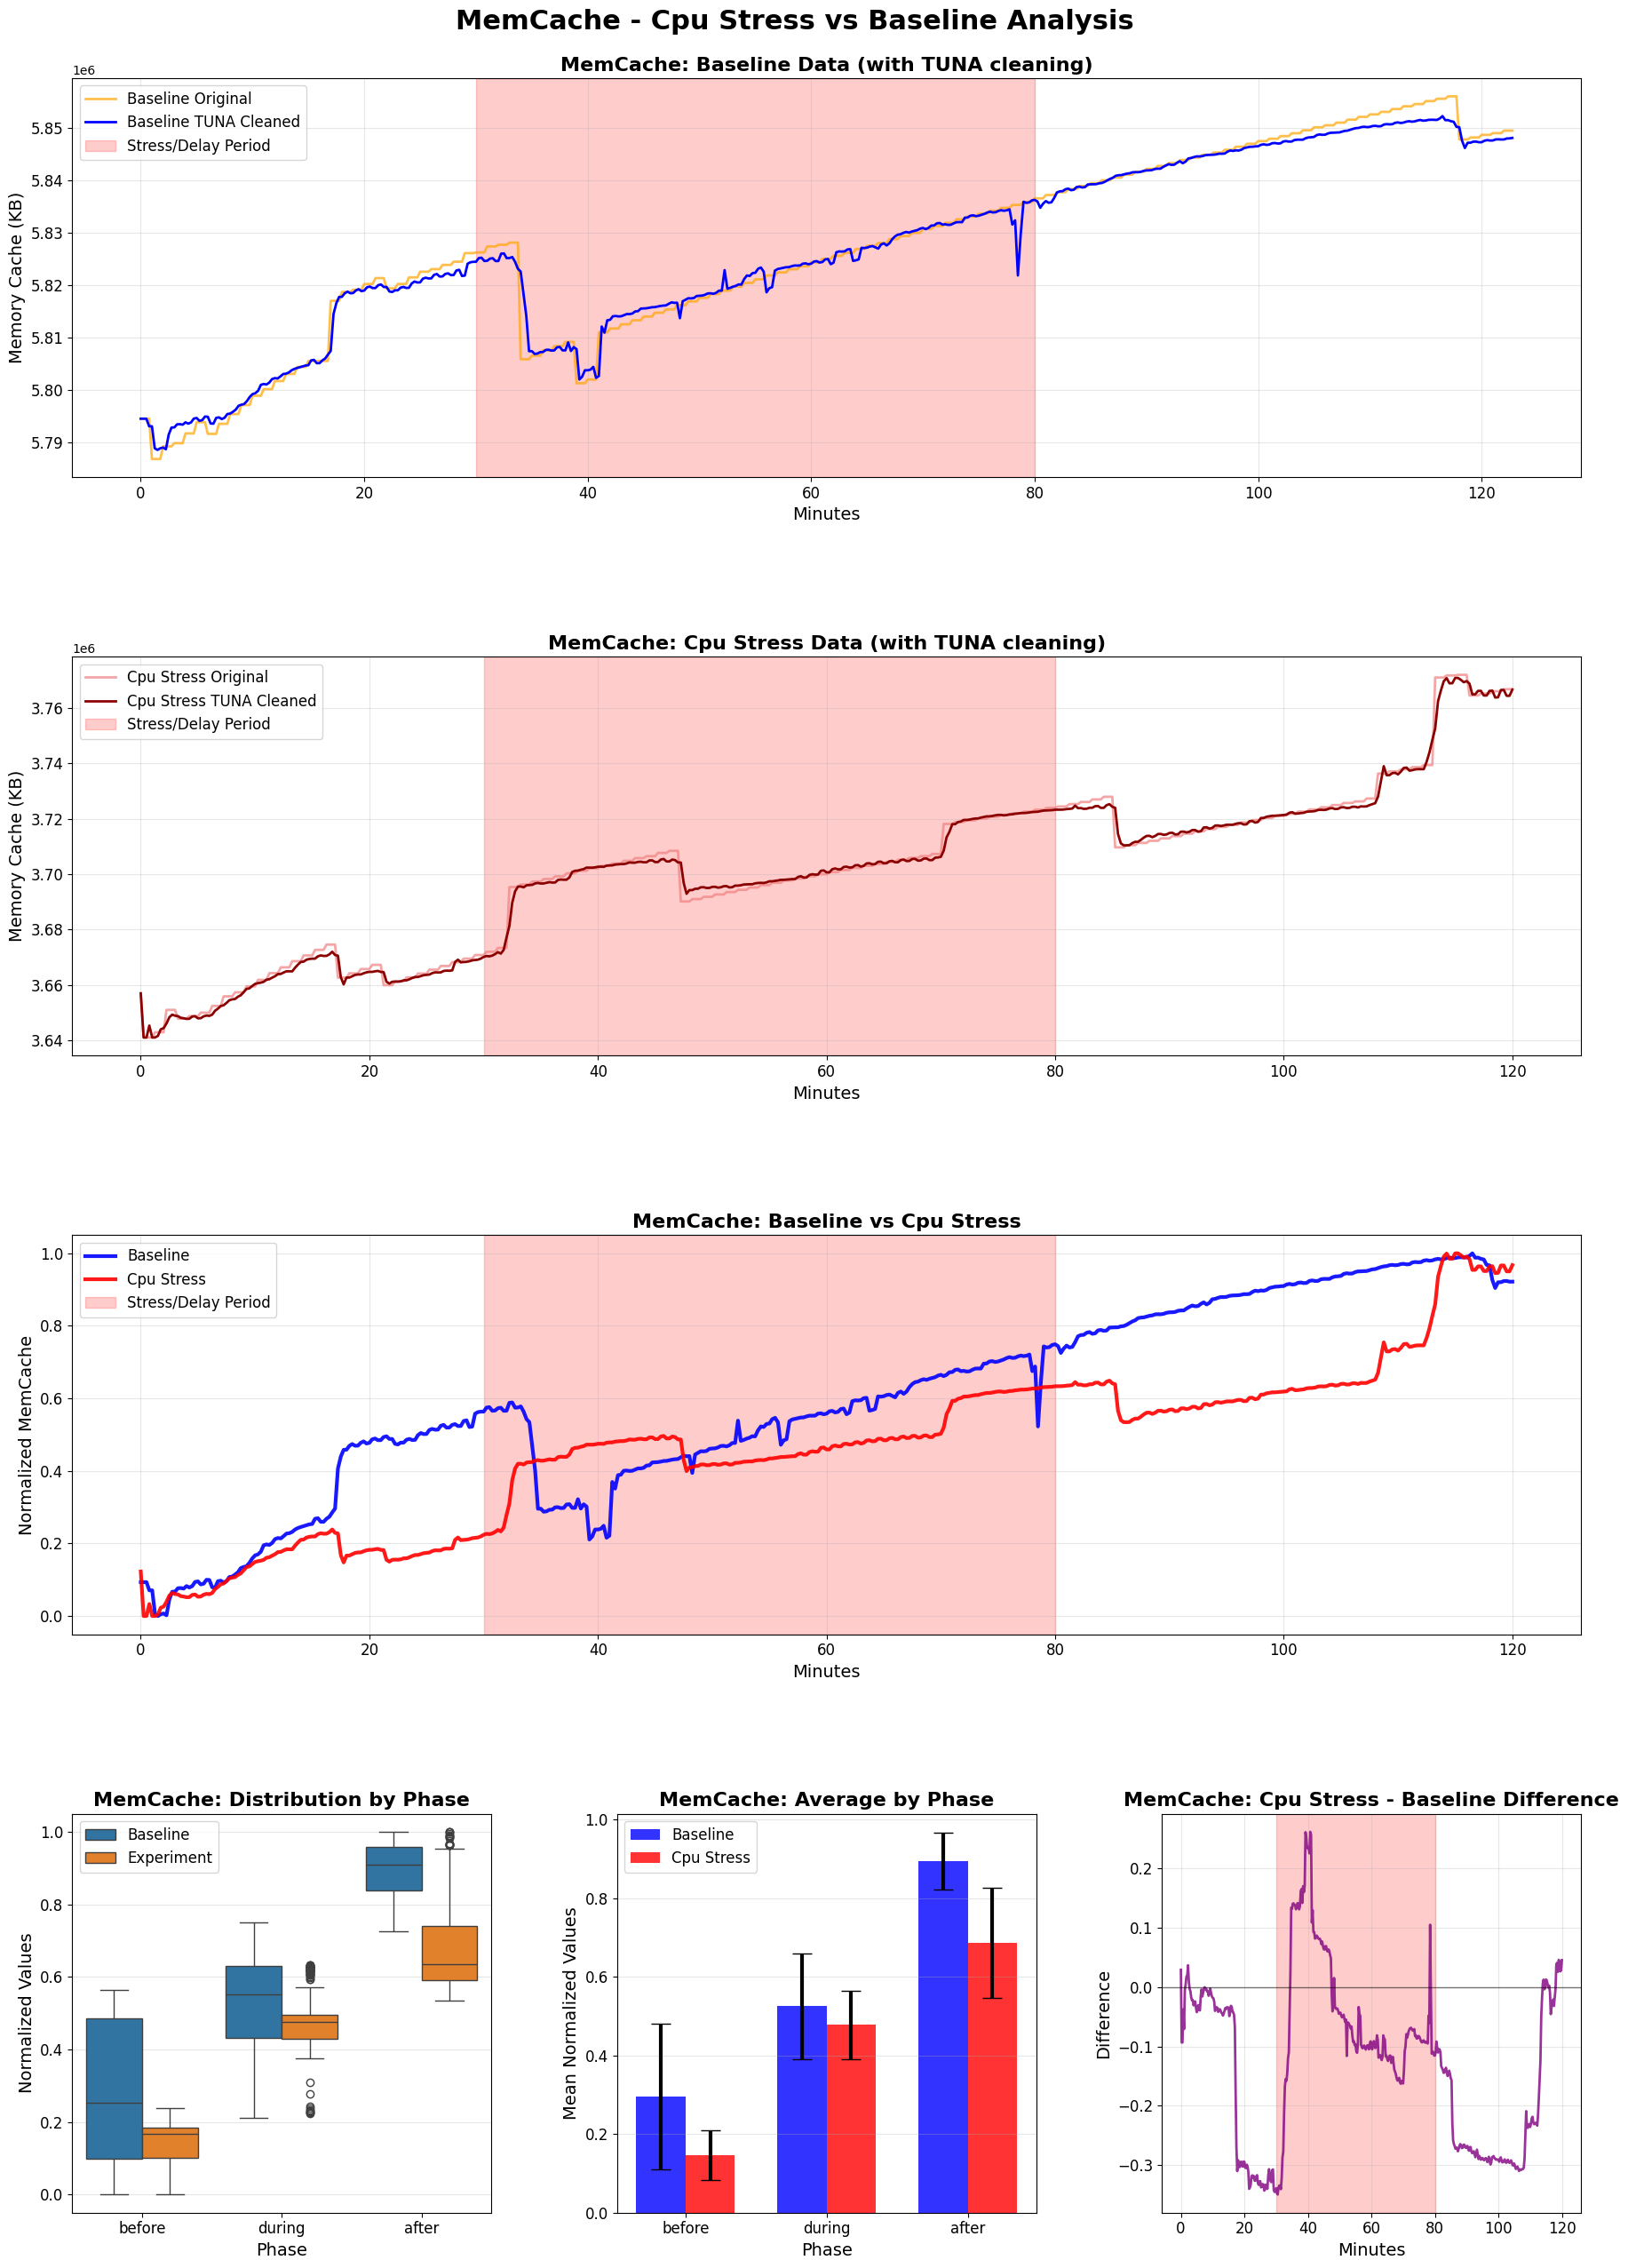

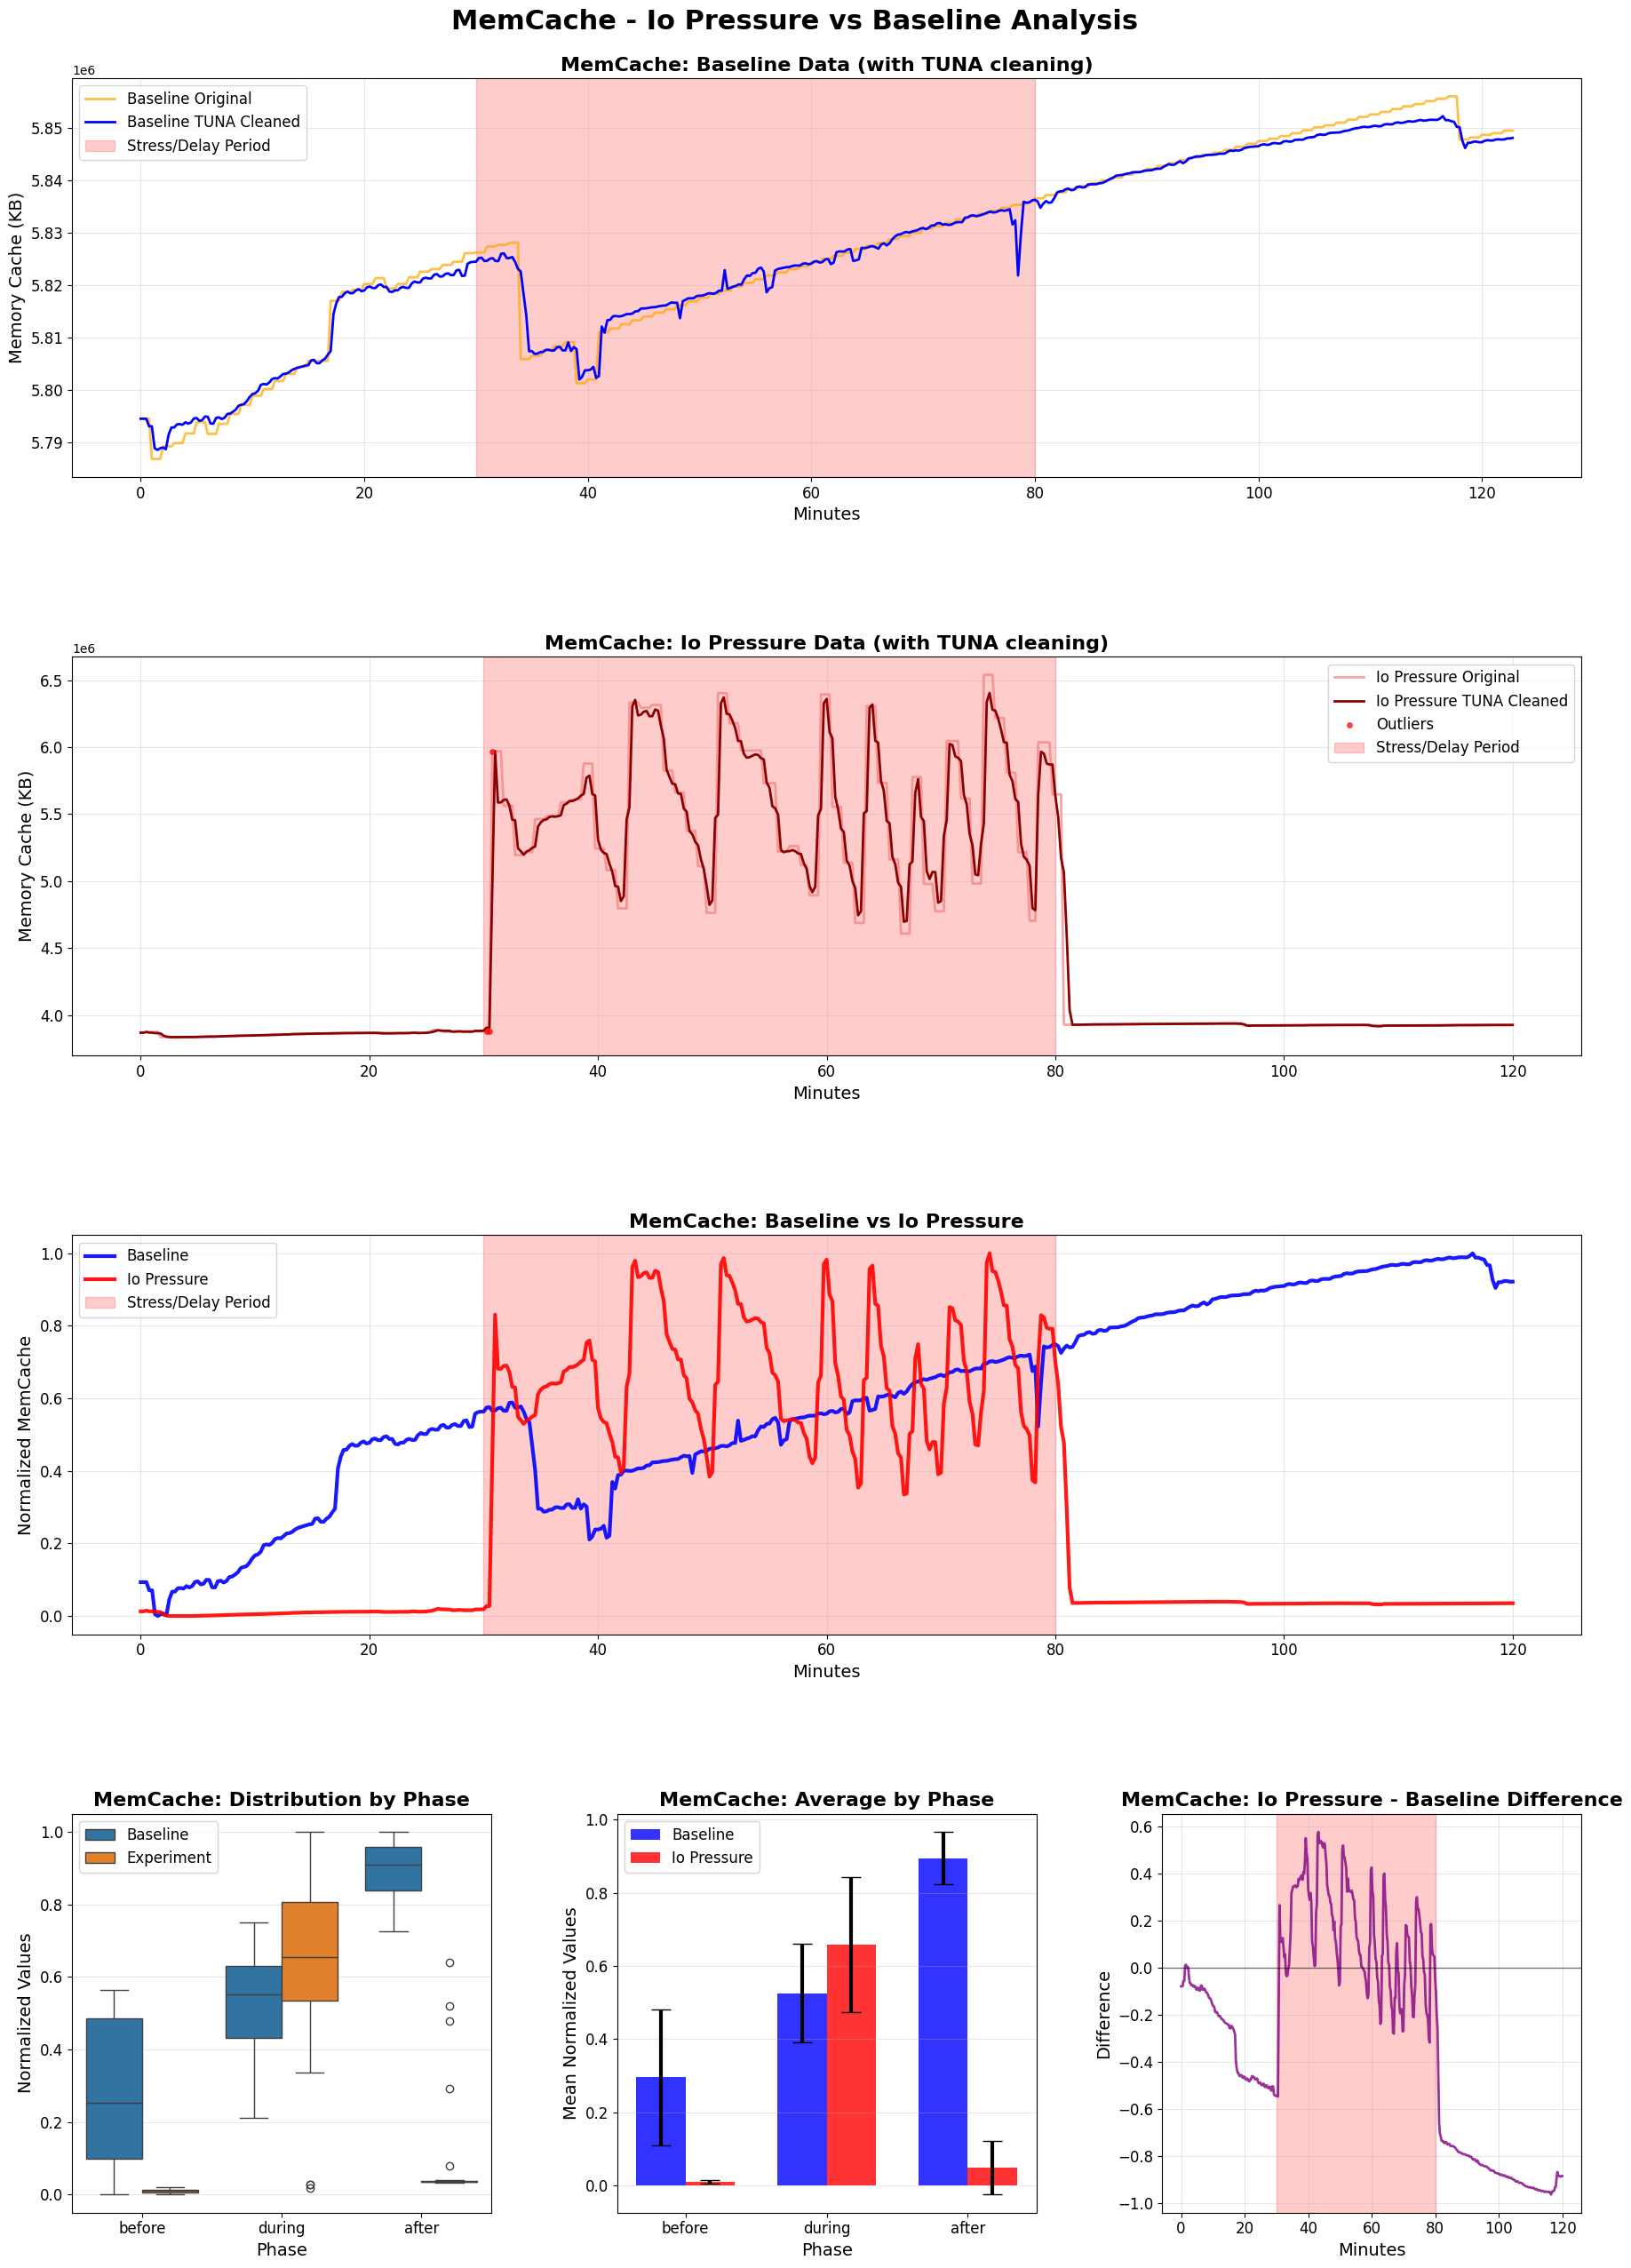

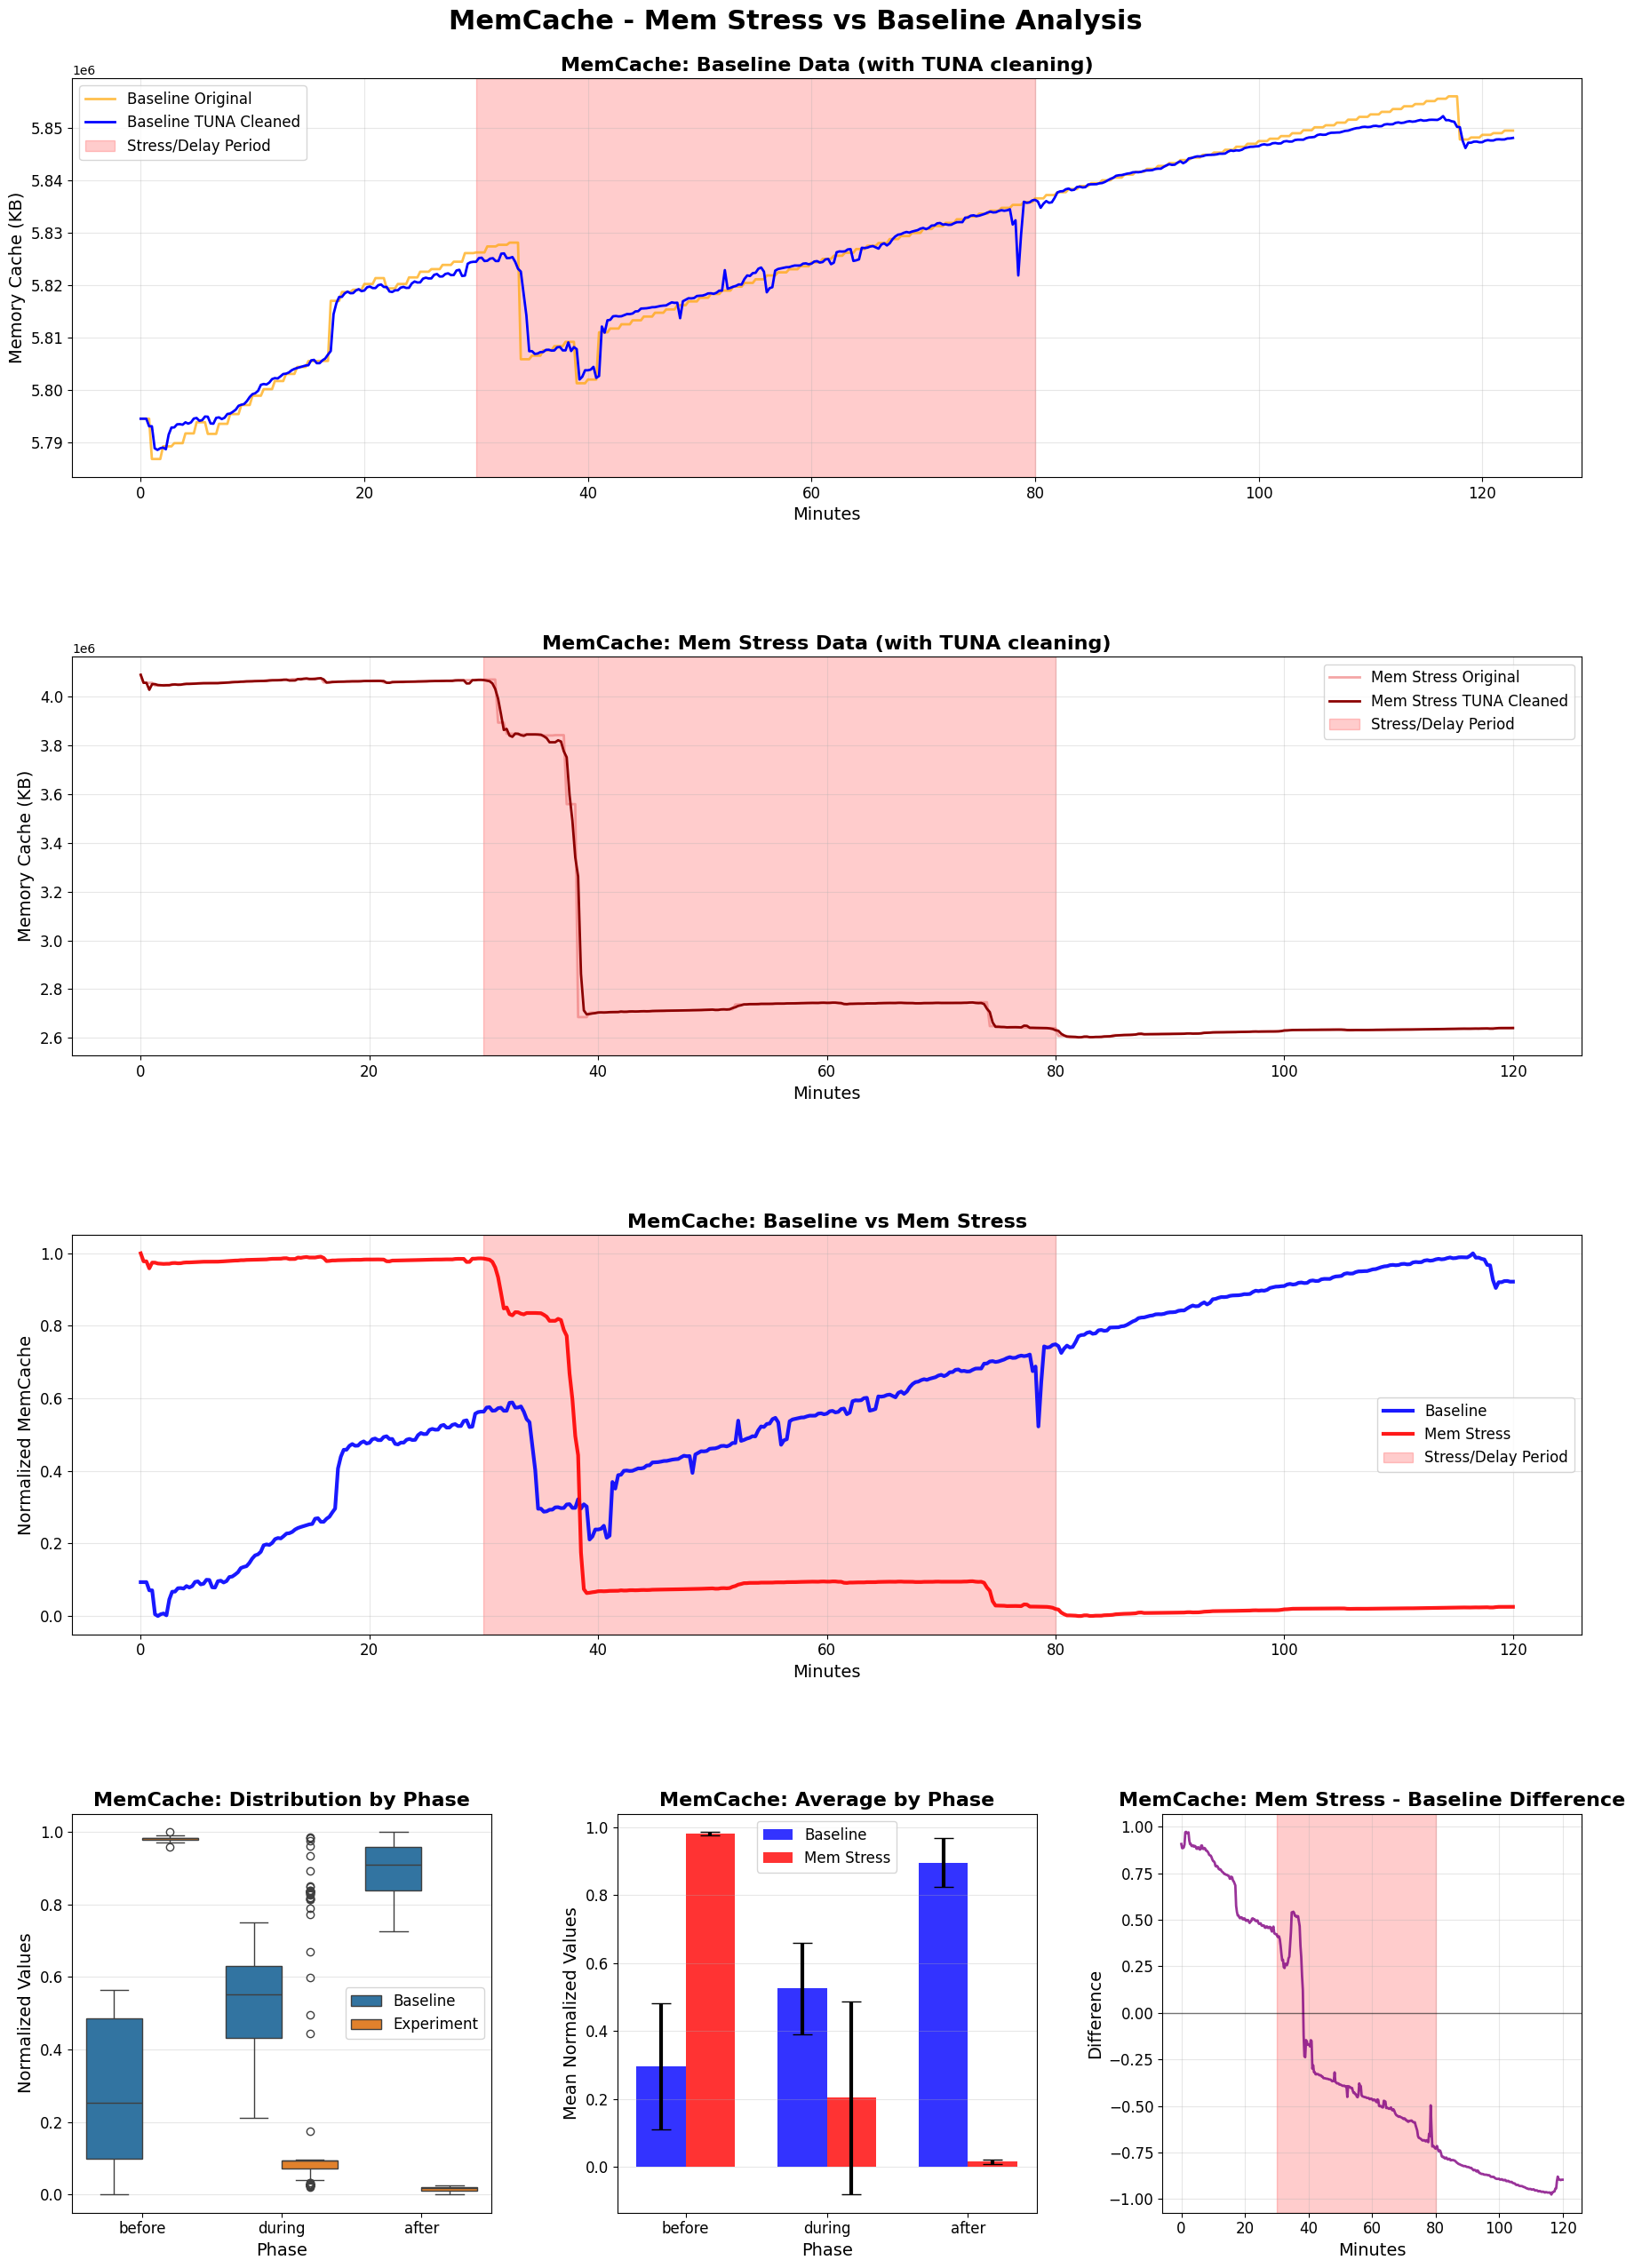

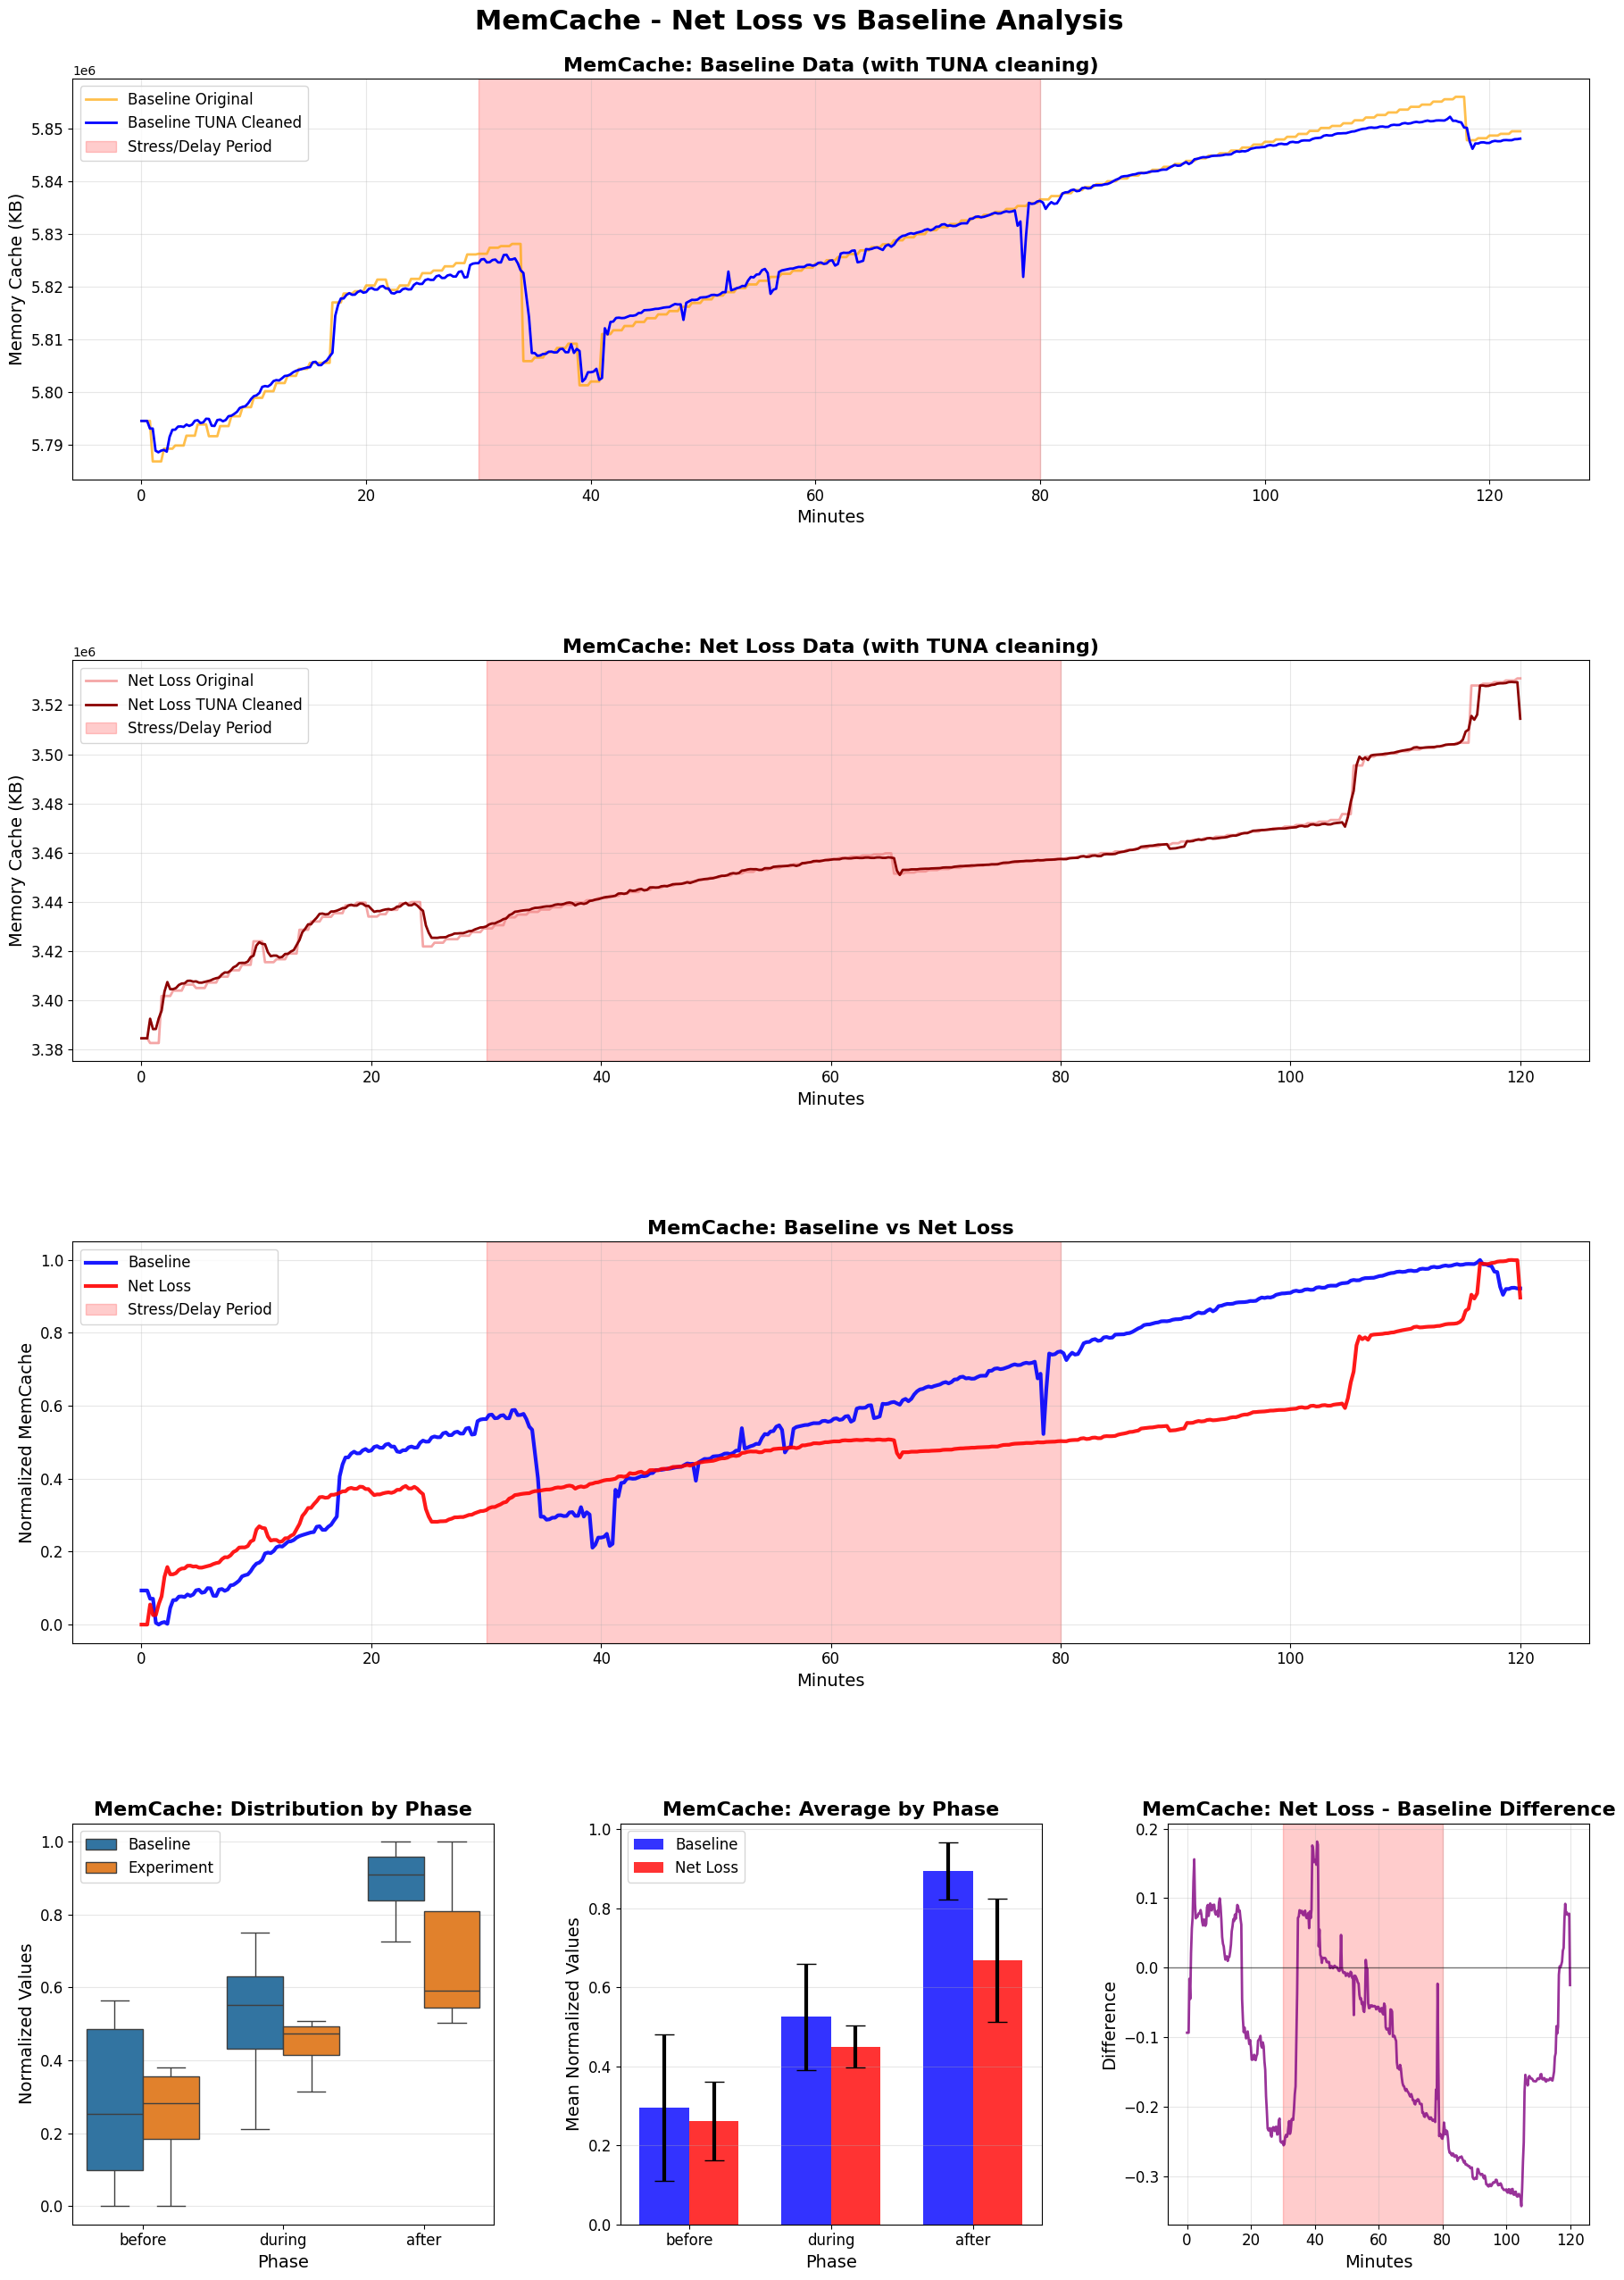

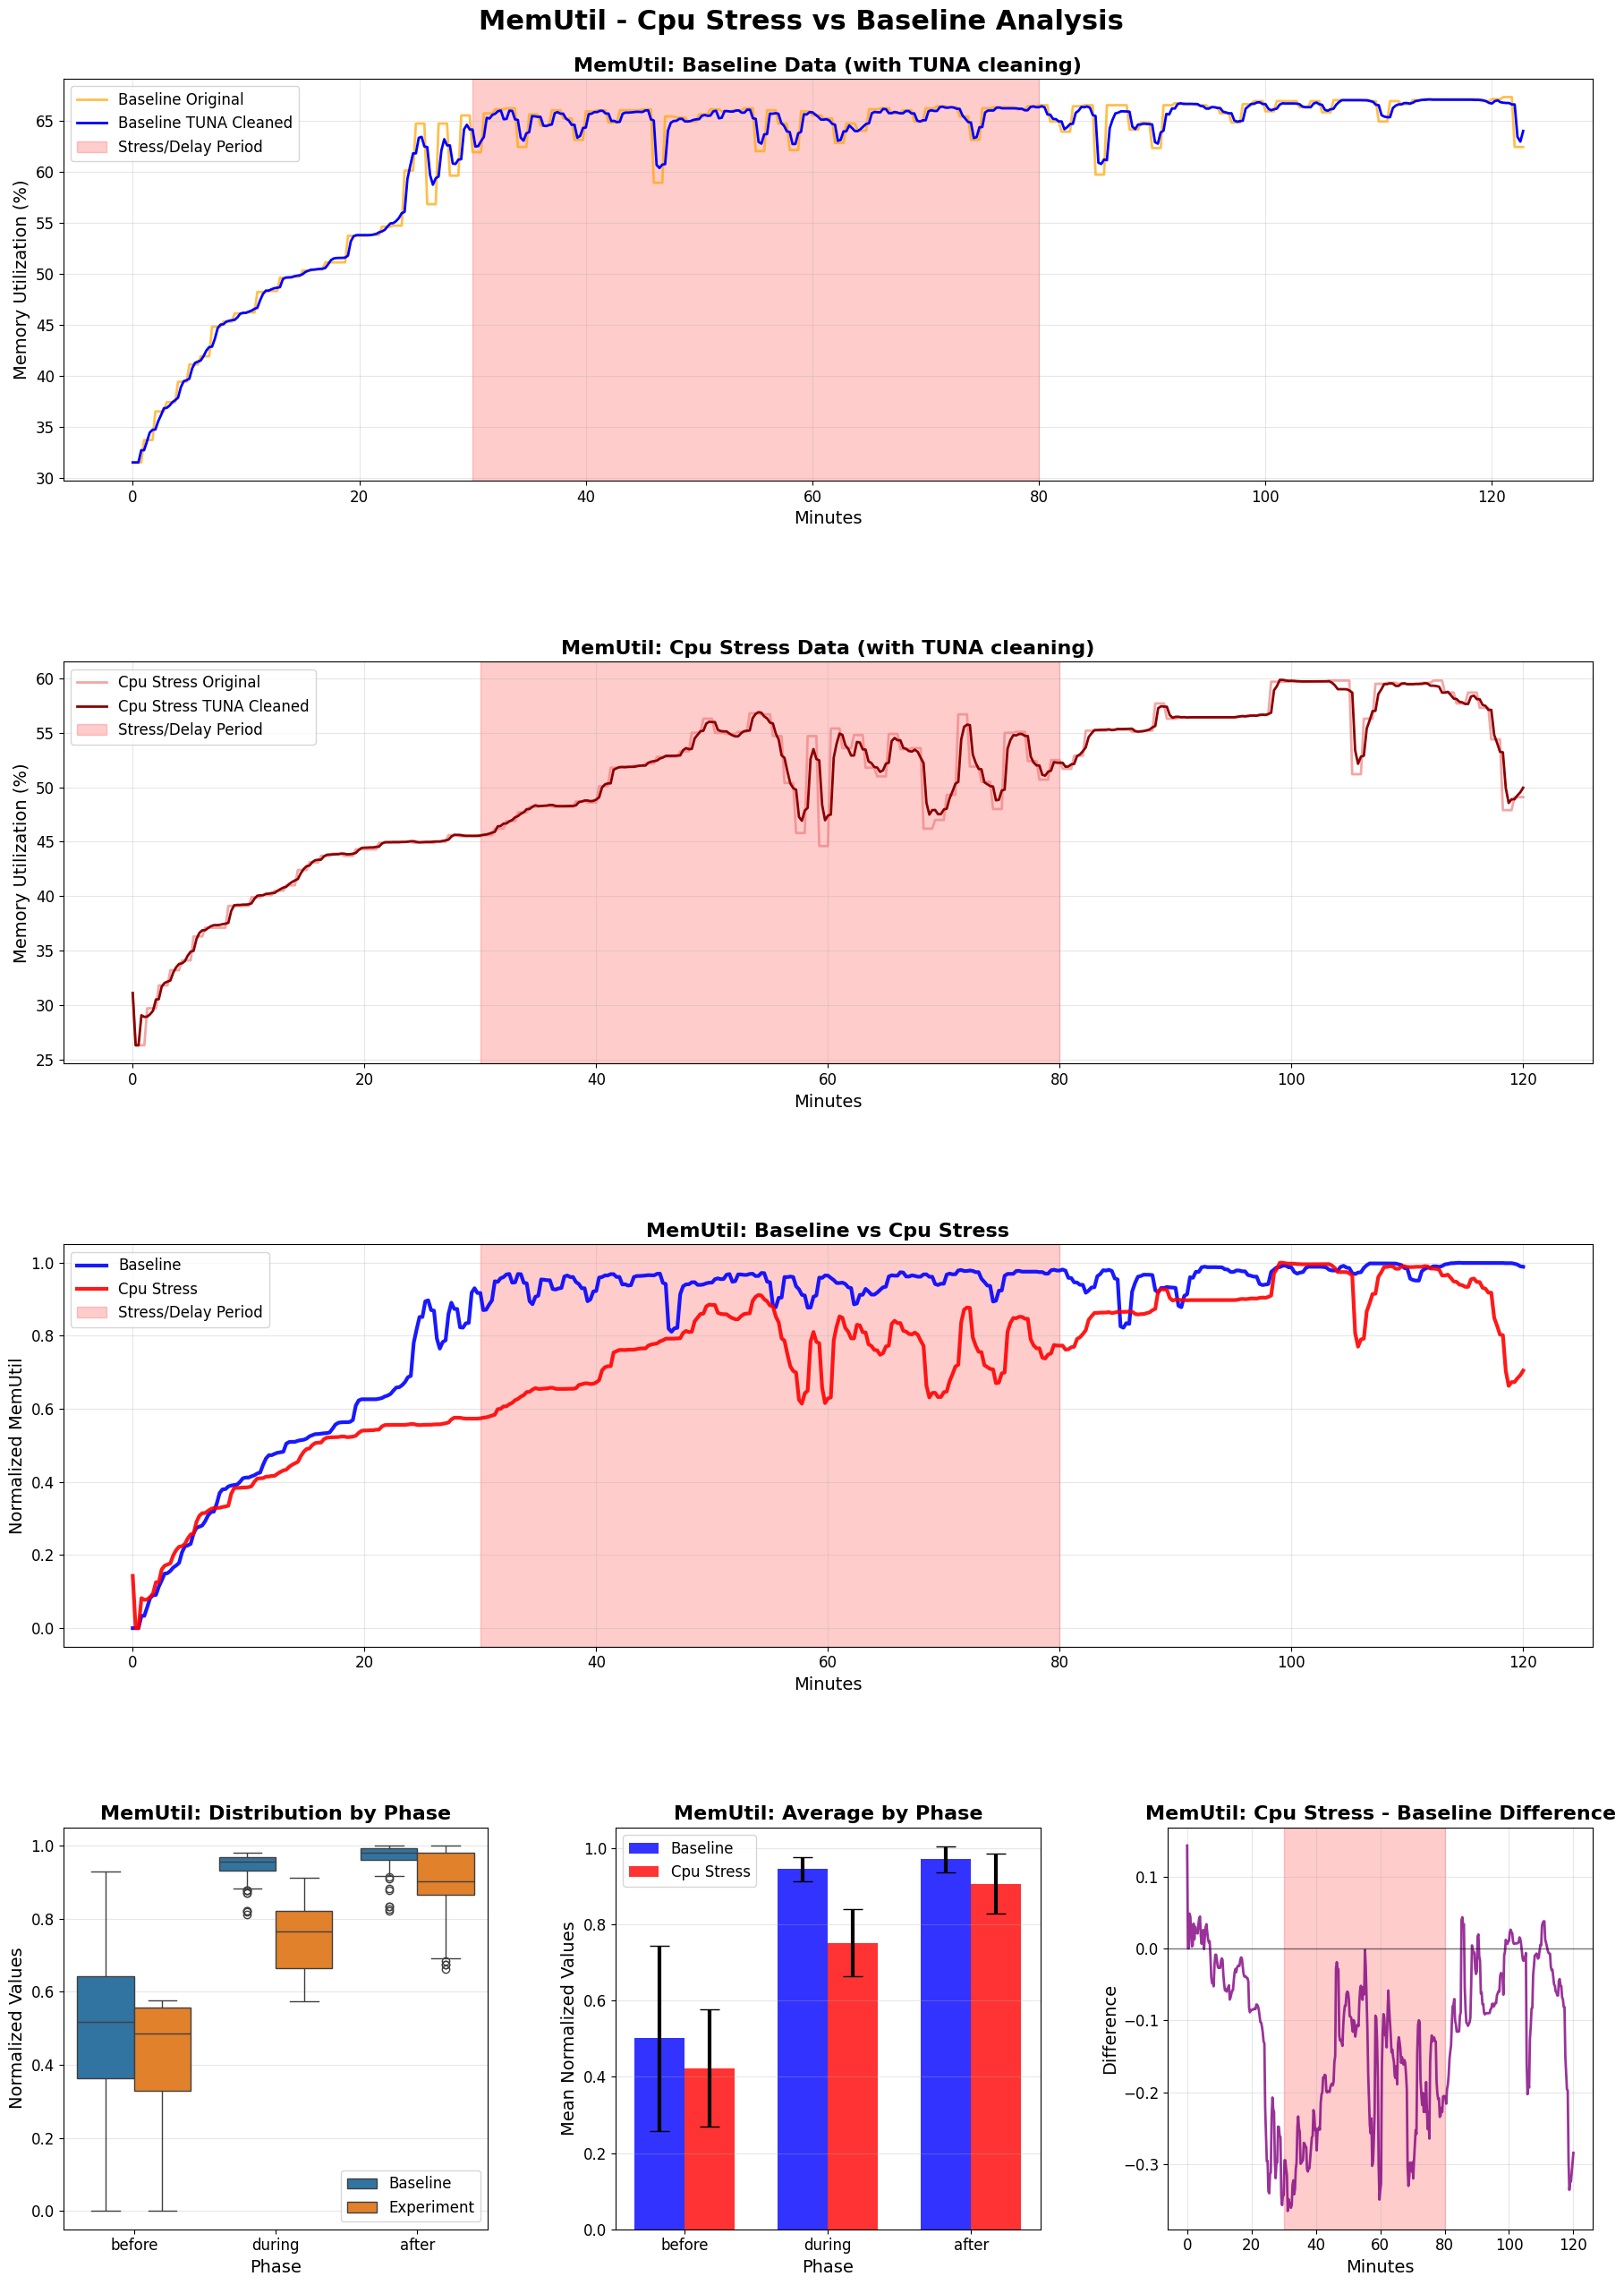

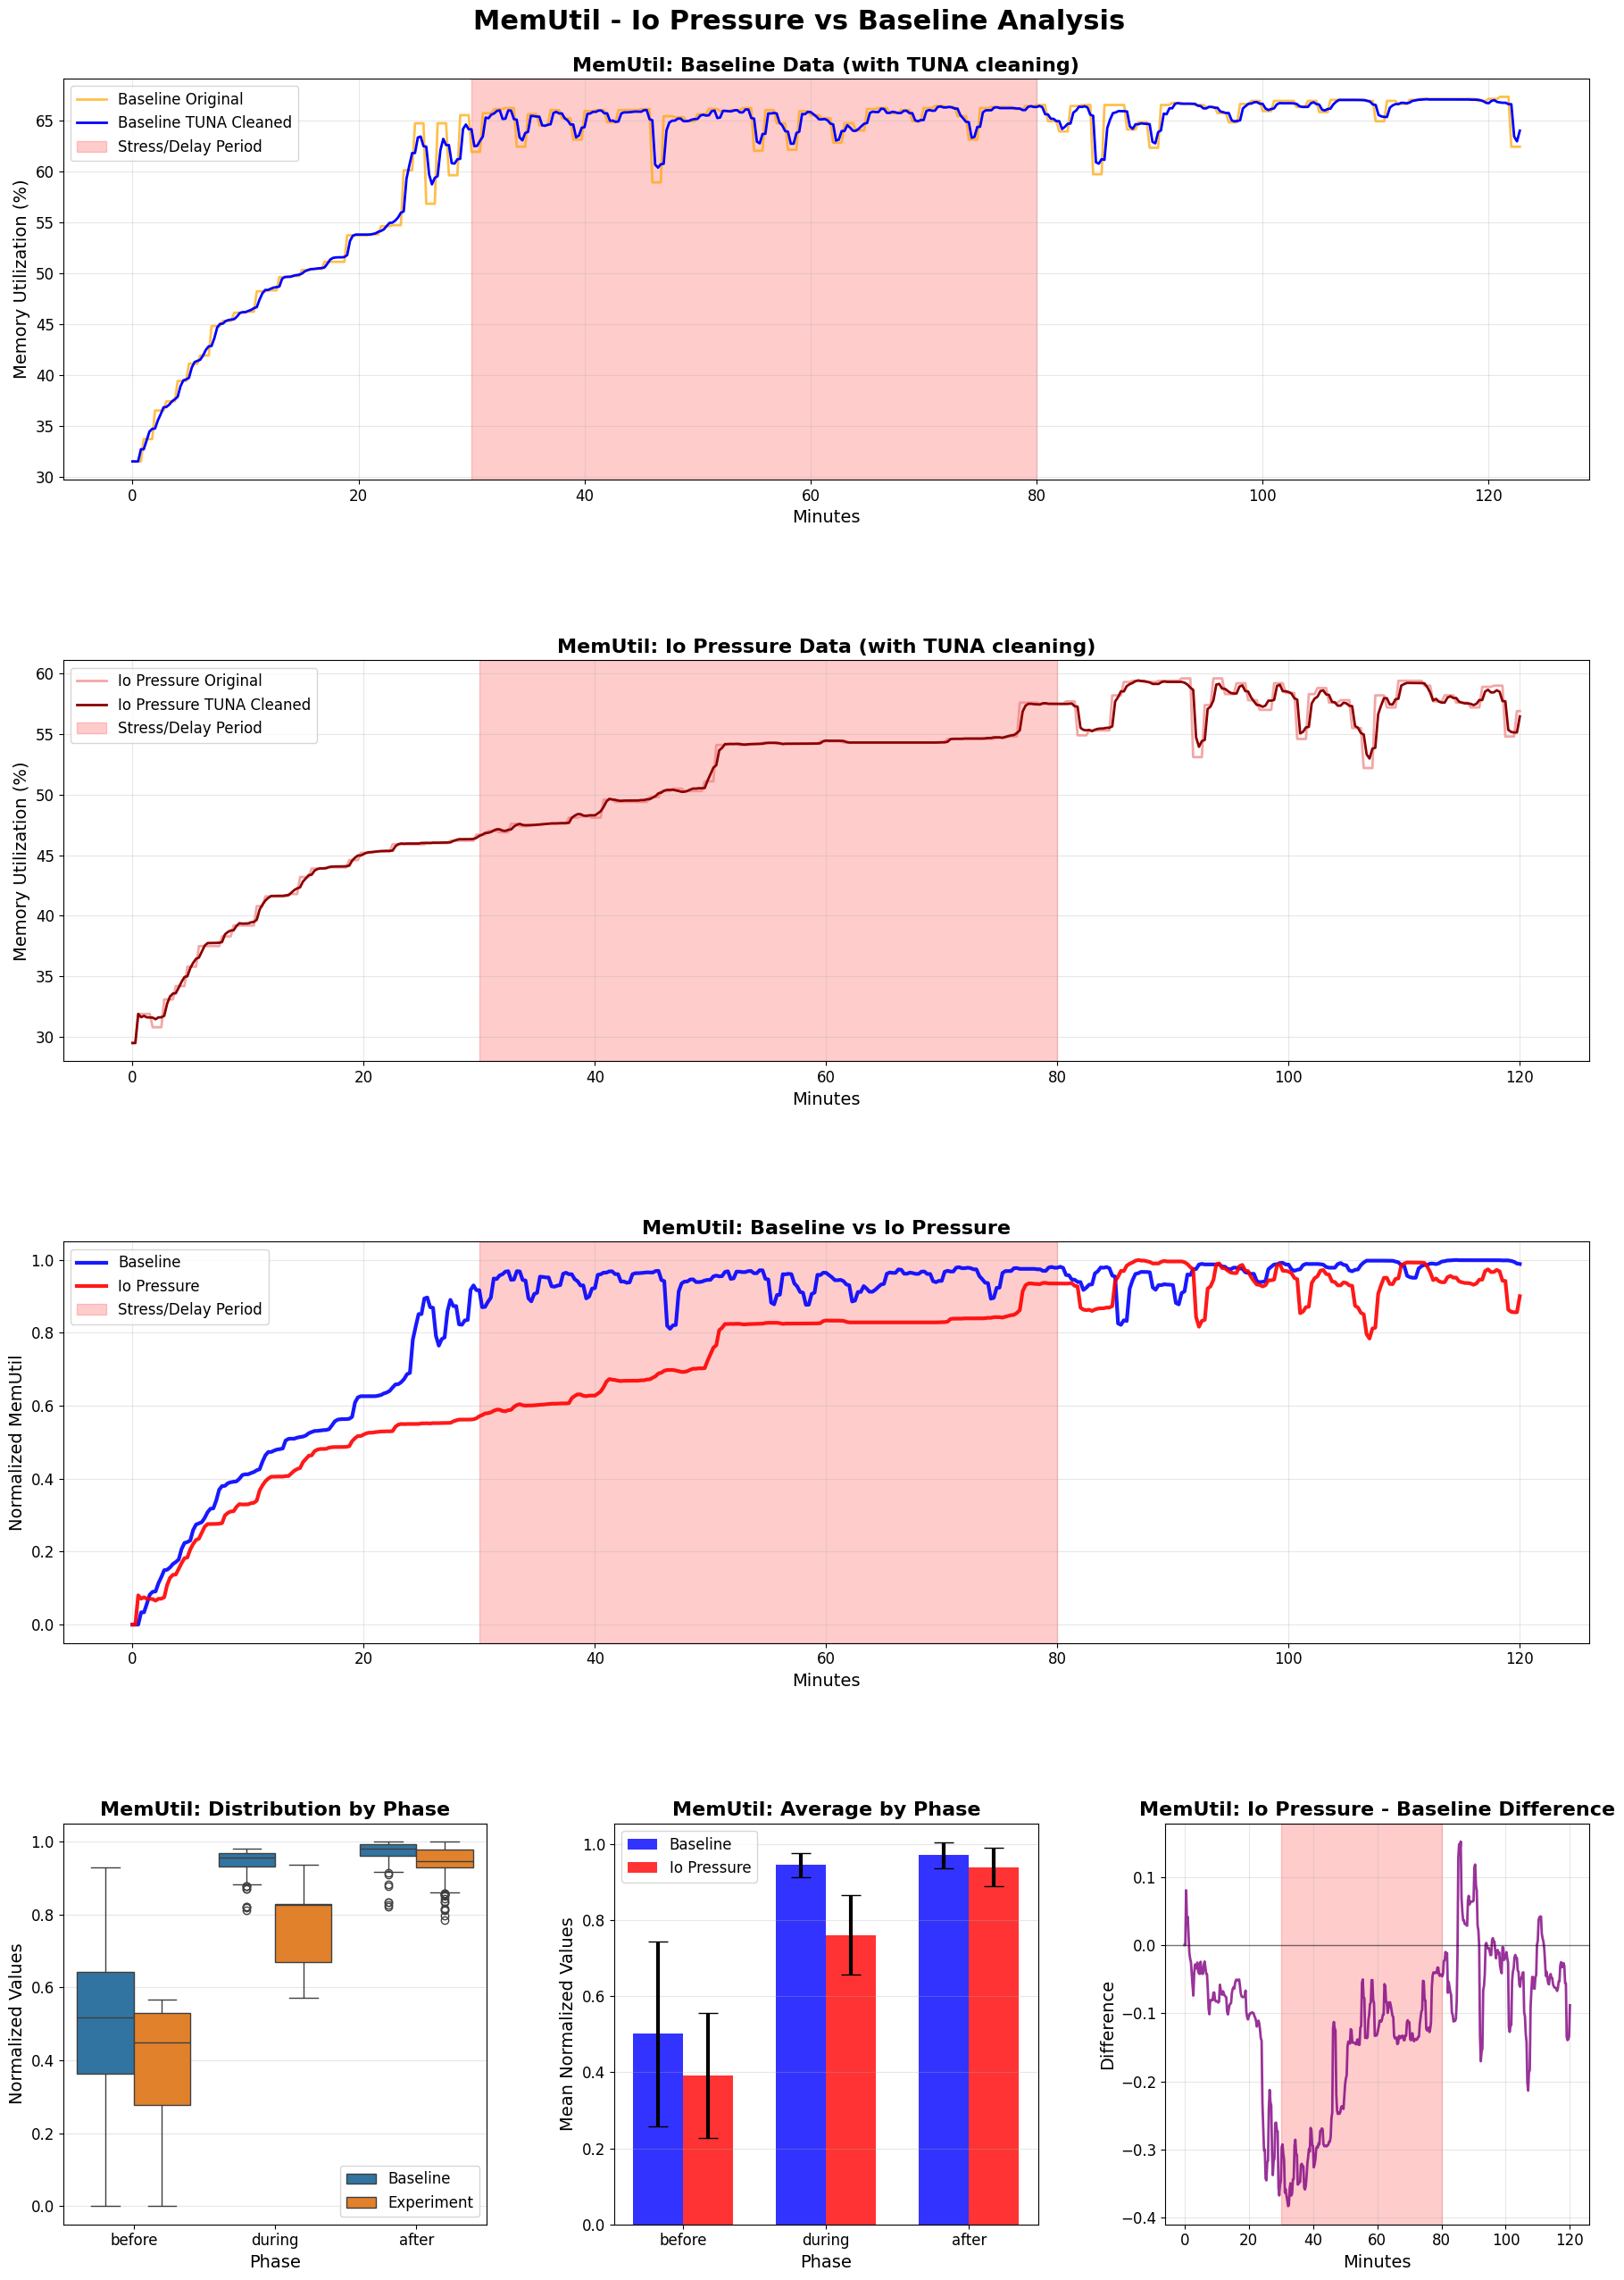

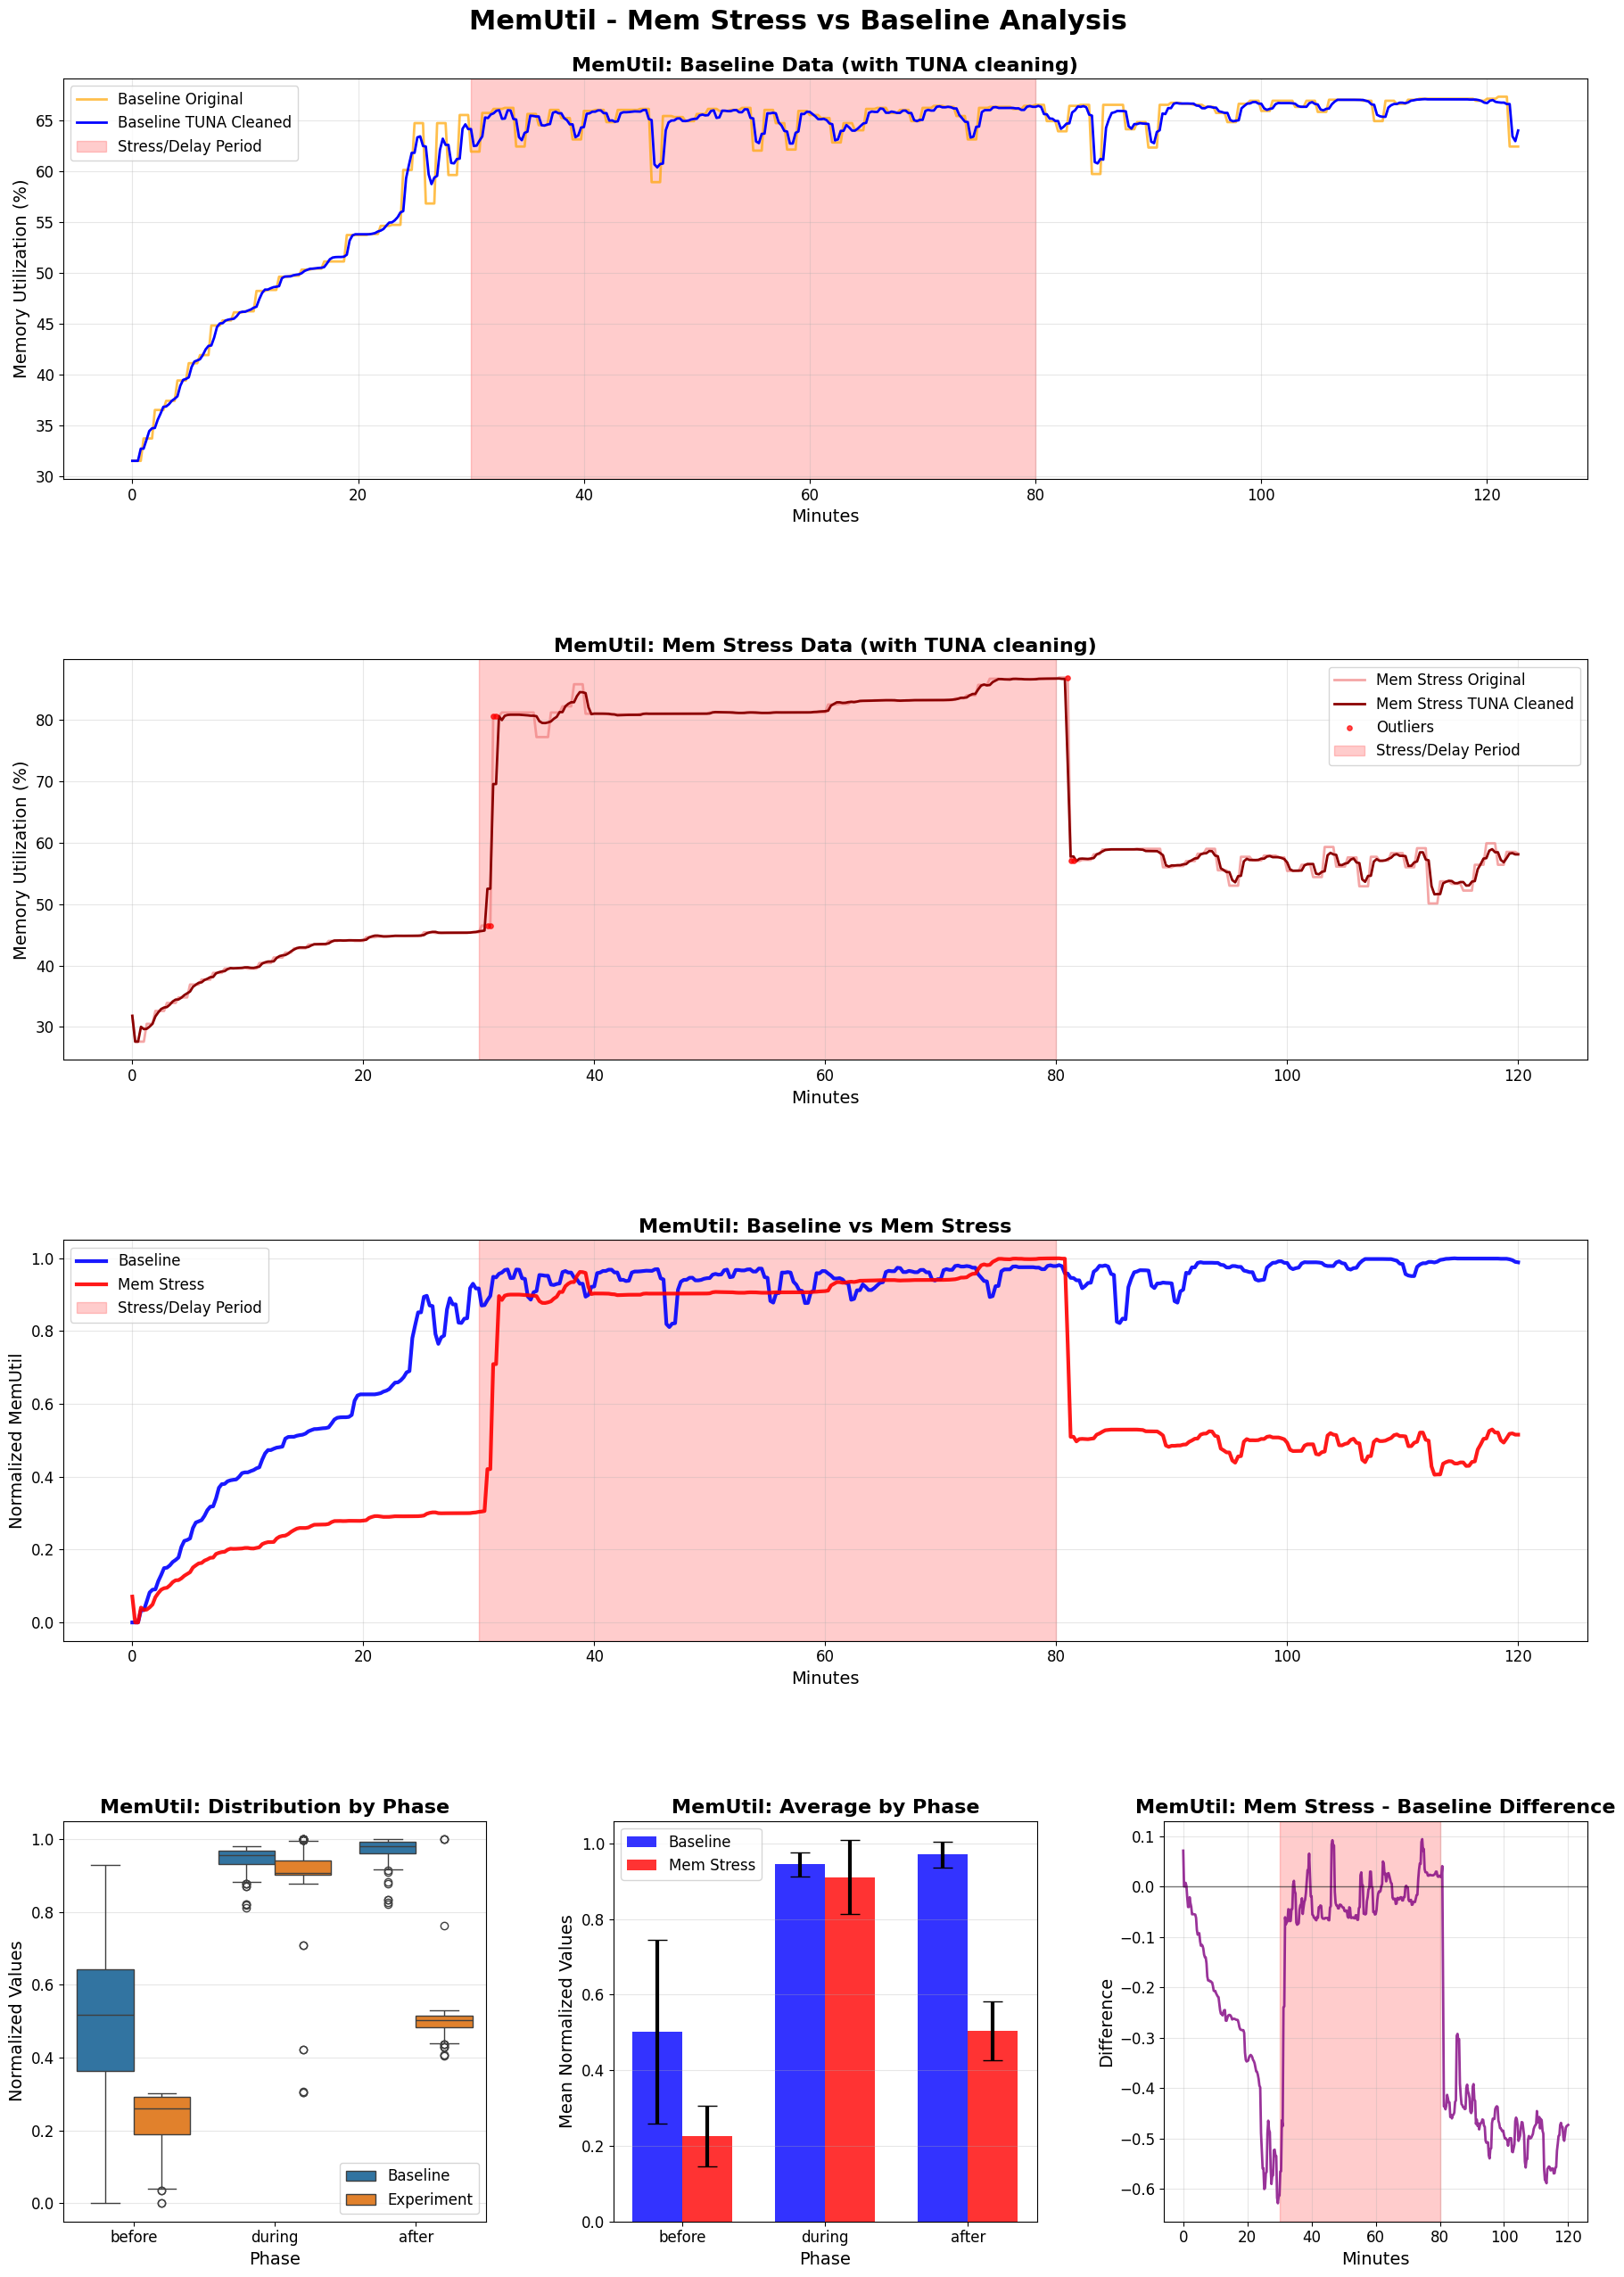

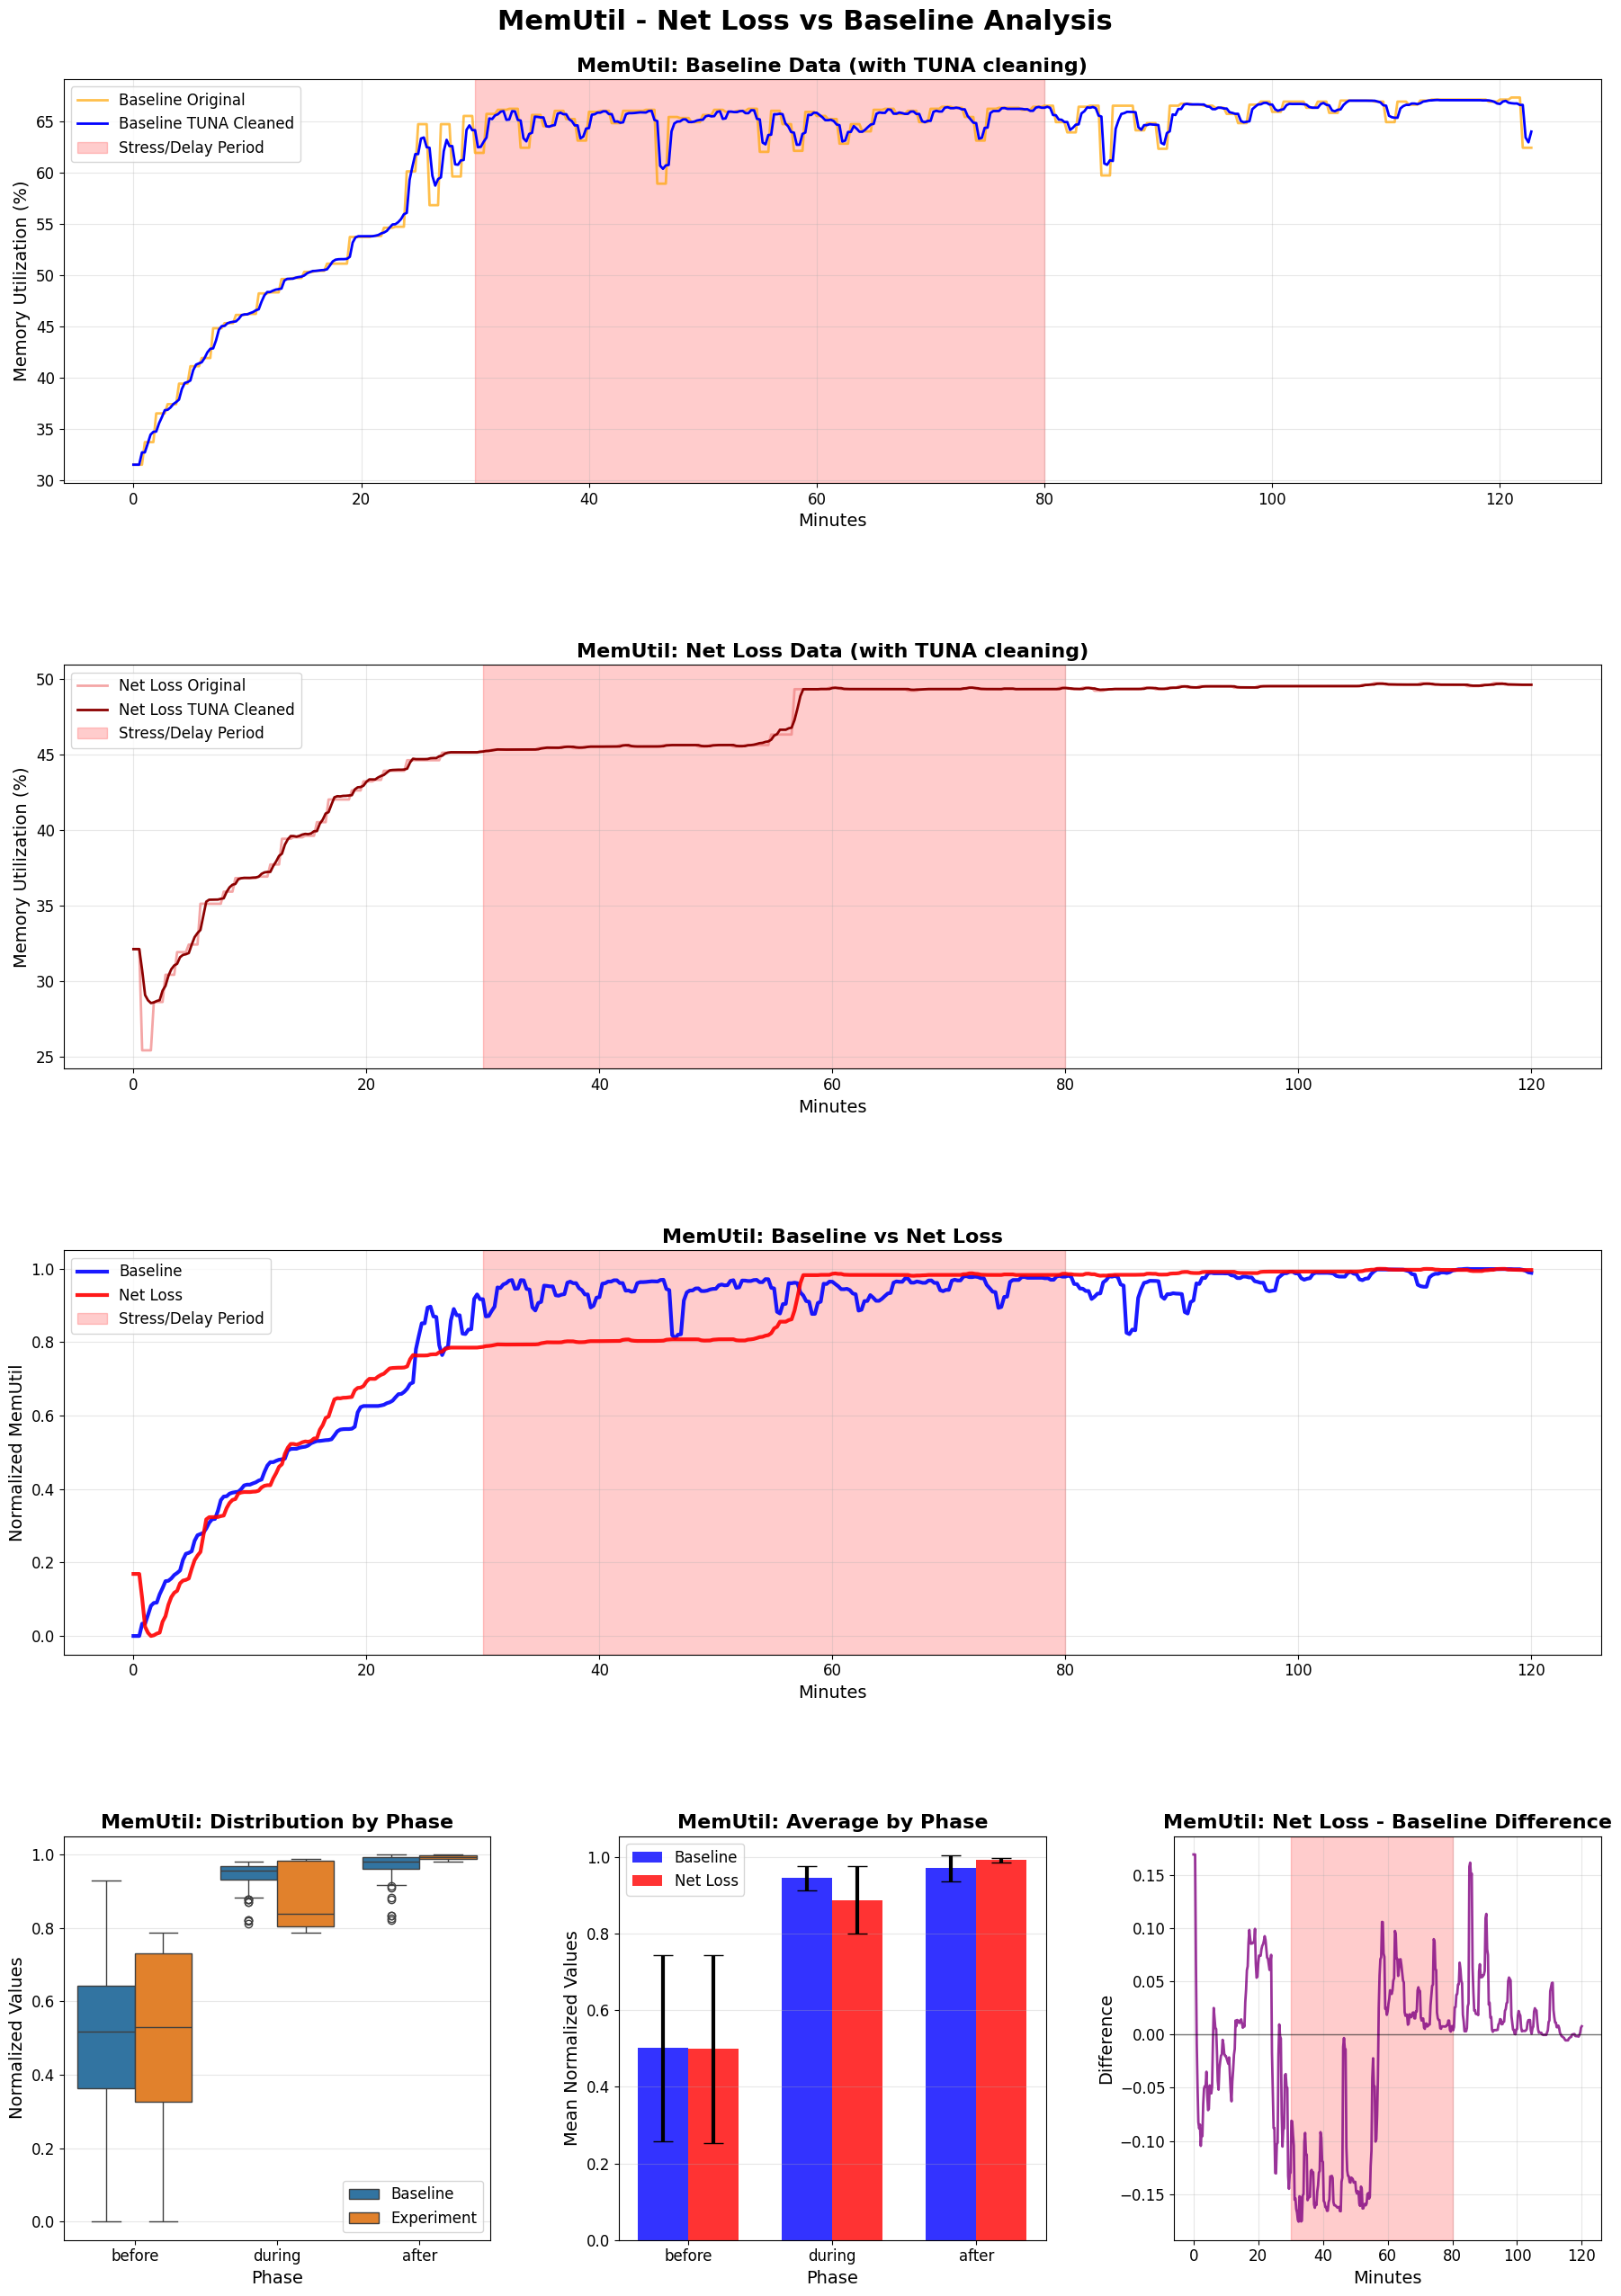

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as scipy_stats

def normalize_series(series):
    if len(series) == 0:
        return series
    
    min_val = series.min()
    max_val = series.max()
    if max_val > min_val:
        return (series - min_val) / (max_val - min_val)
    else:
        return pd.Series(np.zeros(len(series)), index=series.index if hasattr(series, 'index') else None)

def extract_memory_values(df):
    if 'Minutes' not in df.columns and 'Time' in df.columns:
        df['Time'] = pd.to_datetime(df['Time'])
        start_time = df['Time'].iloc[0]
        df['Minutes'] = (df['Time'] - start_time).dt.total_seconds() / 60
    
    if 'mem_cache' in df.columns:
        return df['mem_cache'].values
    elif 'MemCache' in df.columns:
        return df['MemCache'].values
    elif 'MemAvailable' in df.columns:
        return df['MemAvailable'].values
    elif 'MemUtil' in df.columns:
        return df['MemUtil'].values
    else:
        return df.iloc[:, 1].values

def get_memory_y_axis_label(metric_name):
    labels = {
        'MemAvailable': 'Memory Available (KB)',
        'MemCache': 'Memory Cache (KB)', 
        'MemUtil': 'Memory Utilization (%)',
        'mem_cache': 'Memory Cache (KB)'
    }
    return labels.get(metric_name, 'Memory Value')

def extract_tuna_cleaned_data(tuna_results, metric_name, experiment_name):
    if not tuna_results or metric_name not in tuna_results:
        return None, None
    
    if experiment_name not in tuna_results[metric_name]:
        return None, None
        
    exp_results = tuna_results[metric_name][experiment_name]
    
    if 'column_results' in exp_results:
        column_results = exp_results['column_results']
        
        if len(column_results) == 1:
            col_name = list(column_results.keys())[0]
            col_data = column_results[col_name]
            return col_data['cleaned'], col_data['outliers']
        else:
            col_name = list(column_results.keys())[0]
            col_data = column_results[col_name]
            return col_data['cleaned'], col_data['outliers']
    else:
        if 'cleaned' in exp_results and 'outliers' in exp_results:
            return exp_results['cleaned'], exp_results['outliers']
    
    return None, None

def analyze_and_plot_memory_comparison(metric_name, experiment_name, experiment_df, baseline_df, 
                                       tuna_results=None, delay_minutes=30, duration_minutes=50):
    
    experiment_values = extract_memory_values(experiment_df)
    baseline_values = extract_memory_values(baseline_df)
    
    experiment_cleaned = None
    baseline_cleaned = None
    experiment_outliers = None
    baseline_outliers = None
    
    if tuna_results and metric_name in tuna_results:
        exp_cleaned, exp_outliers = extract_tuna_cleaned_data(tuna_results, metric_name, experiment_name)
        if exp_cleaned is not None:
            experiment_cleaned = exp_cleaned
            experiment_outliers = exp_outliers
        
        baseline_cleaned_data, baseline_outliers_data = extract_tuna_cleaned_data(tuna_results, metric_name, 'baseline')
        if baseline_cleaned_data is not None:
            baseline_cleaned = baseline_cleaned_data
            baseline_outliers = baseline_outliers_data
    
    experiment_series = experiment_cleaned if experiment_cleaned is not None else experiment_values
    baseline_series = baseline_cleaned if baseline_cleaned is not None else baseline_values
    
    experiment_norm = normalize_series(pd.Series(experiment_series))
    baseline_norm = normalize_series(pd.Series(baseline_series))
    
    if 'Minutes' not in experiment_df.columns:
        experiment_df['Minutes'] = range(len(experiment_df))
    if 'Minutes' not in baseline_df.columns:
        baseline_df['Minutes'] = range(len(baseline_df))
    
    min_length = min(len(experiment_norm), len(baseline_norm), 
                     len(experiment_df['Minutes']), len(baseline_df['Minutes']))
    
    df_combined = pd.DataFrame({
        'Baseline': baseline_norm.iloc[:min_length],
        'Experiment': experiment_norm.iloc[:min_length],
        'Minutes': experiment_df['Minutes'].iloc[:min_length],
        'Baseline_Minutes': baseline_df['Minutes'].iloc[:min_length]
    })
    
    df_combined['difference'] = df_combined['Experiment'] - df_combined['Baseline']
    
    df_combined['phase'] = 'before'
    df_combined.loc[(df_combined['Minutes'] >= delay_minutes) & 
                    (df_combined['Minutes'] <= delay_minutes + duration_minutes), 'phase'] = 'during'
    df_combined.loc[df_combined['Minutes'] > delay_minutes + duration_minutes, 'phase'] = 'after'
    
    stats_baseline = df_combined.groupby('phase')['Baseline'].agg(['mean', 'std', 'min', 'max'])
    stats_experiment = df_combined.groupby('phase')['Experiment'].agg(['mean', 'std', 'min', 'max'])
    
    t_tests = {}
    available_phases = stats_baseline.index.tolist()
    
    for phase in ['before', 'during', 'after']:
        if phase in available_phases:
            data = df_combined[df_combined['phase'] == phase]
            if len(data) > 1:
                t_stat, p_value = scipy_stats.ttest_ind(data['Baseline'].dropna(), data['Experiment'].dropna())
                t_tests[phase] = {'t': t_stat, 'p': p_value}
            else:
                t_tests[phase] = {'t': 0, 'p': 1}
        else:
            t_tests[phase] = {'t': 0, 'p': 1, 'note': 'Phase not present in data'}
    
    impact = {}
    for phase in ['before', 'during', 'after']:
        if phase in available_phases:
            baseline_mean = stats_baseline.loc[phase, 'mean']
            experiment_mean = stats_experiment.loc[phase, 'mean']
            if baseline_mean != 0:
                impact[phase] = ((experiment_mean - baseline_mean) / baseline_mean) * 100
            else:
                impact[phase] = 0
        else:
            impact[phase] = 0
    
    fig = plt.figure(figsize=(18, 26))
    y_label = get_memory_y_axis_label(metric_name)
    
    plt.subplot(4, 1, 1)
    plt.plot(baseline_df['Minutes'][:len(baseline_values)], baseline_values, 
             label='Baseline Original', color='orange', alpha=0.7, linewidth=2)
    
    if baseline_cleaned is not None:
        plt.plot(baseline_df['Minutes'][:len(baseline_cleaned)], baseline_cleaned, 
                 label='Baseline TUNA Cleaned', linewidth=2, color='blue')
        
        if baseline_outliers is not None:
            outlier_points = np.where(baseline_outliers)[0]
            if len(outlier_points) > 0:
                plt.scatter(baseline_df['Minutes'].iloc[outlier_points], 
                           baseline_values[outlier_points], 
                           c='red', s=15, alpha=0.7, label='Outliers', zorder=5)
        
        title_suffix = " (with TUNA cleaning)"
    else:
        title_suffix = ""
    
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Stress/Delay Period")
    plt.title(f'{metric_name}: Baseline Data{title_suffix}', fontsize=16, fontweight='bold')
    plt.xlabel('Minutes', fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.subplot(4, 1, 2)
    plt.plot(experiment_df['Minutes'][:len(experiment_values)], experiment_values, 
             label=f'{experiment_name.replace("_", " ").title()} Original', 
             alpha=0.7, color='lightcoral', linewidth=2)
    
    if experiment_cleaned is not None:
        plt.plot(experiment_df['Minutes'][:len(experiment_cleaned)], experiment_cleaned, 
                 label=f'{experiment_name.replace("_", " ").title()} TUNA Cleaned', 
                 linewidth=2, color='darkred')
        
        if experiment_outliers is not None:
            outlier_points = np.where(experiment_outliers)[0]
            if len(outlier_points) > 0:
                plt.scatter(experiment_df['Minutes'].iloc[outlier_points], 
                           experiment_values[outlier_points], 
                           c='red', s=15, alpha=0.7, label='Outliers', zorder=5)
        
        title_suffix = " (with TUNA cleaning)"
    else:
        title_suffix = ""
    
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Stress/Delay Period")
    plt.title(f'{metric_name}: {experiment_name.replace("_", " ").title()} Data{title_suffix}', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Minutes', fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.subplot(4, 1, 3)
    plt.plot(df_combined['Minutes'], df_combined['Baseline'], 
             label='Baseline', linewidth=3, color='blue', alpha=0.9)
    plt.plot(df_combined['Minutes'], df_combined['Experiment'], 
             label=f'{experiment_name.replace("_", " ").title()}', linewidth=3, color='red', alpha=0.9)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Stress/Delay Period")
    plt.title(f"{metric_name}: Baseline vs {experiment_name.replace('_', ' ').title()}", 
              fontsize=16, fontweight='bold')
    plt.xlabel("Minutes", fontsize=14)
    plt.ylabel(f"Normalized {metric_name}", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.subplot(4, 3, 10)
    box_data = pd.melt(df_combined[['Baseline', 'Experiment', 'phase']], 
                       id_vars=['phase'], var_name='source', value_name='value')
    sns.boxplot(x='phase', y='value', hue='source', data=box_data, ax=plt.gca())
    plt.title(f'{metric_name}: Distribution by Phase', fontsize=16, fontweight='bold')
    plt.xlabel('Phase', fontsize=14)
    plt.ylabel('Normalized Values', fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.subplot(4, 3, 11)
    phases_to_plot = [p for p in ['before', 'during', 'after'] if p in available_phases]
    
    if len(phases_to_plot) > 0:
        x = np.arange(len(phases_to_plot))
        width = 0.35
        
        baseline_means = [stats_baseline.loc[p, 'mean'] for p in phases_to_plot]
        baseline_stds = [stats_baseline.loc[p, 'std'] for p in phases_to_plot]
        experiment_means = [stats_experiment.loc[p, 'mean'] for p in phases_to_plot]
        experiment_stds = [stats_experiment.loc[p, 'std'] for p in phases_to_plot]
        
        bars1 = plt.bar(x - width/2, baseline_means, width, 
                        label='Baseline', alpha=0.8, color='blue')
        bars2 = plt.bar(x + width/2, experiment_means, width, 
                        label=f'{experiment_name.replace("_", " ").title()}', alpha=0.8, color='red')
        
        plt.errorbar(x - width/2, baseline_means, yerr=baseline_stds, 
                     fmt='none', ecolor='black', capsize=8, linewidth=3)
        plt.errorbar(x + width/2, experiment_means, yerr=experiment_stds, 
                     fmt='none', ecolor='black', capsize=8, linewidth=3)
        
        plt.xticks(x, phases_to_plot)
    else:
        plt.text(0.5, 0.5, 'No phase data available', ha='center', va='center', 
                 transform=plt.gca().transAxes, fontsize=14)
    
    plt.title(f'{metric_name}: Average by Phase', fontsize=16, fontweight='bold')
    plt.xlabel('Phase', fontsize=14)
    plt.ylabel('Mean Normalized Values', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.subplot(4, 3, 12)
    plt.plot(df_combined['Minutes'], df_combined['difference'], 
             color='purple', linewidth=2, alpha=0.8)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2)
    plt.title(f'{metric_name}: {experiment_name.replace("_", " ").title()} - Baseline Difference', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Minutes', fontsize=14)
    plt.ylabel('Difference', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.suptitle(f'{metric_name} - {experiment_name.replace("_", " ").title()} vs Baseline Analysis', 
                 fontsize=22, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, hspace=0.45, wspace=0.3)
    plt.show()
    
    return {
        'stats_baseline': stats_baseline,
        'stats_experiment': stats_experiment,
        't_tests': t_tests,
        'impact': impact,
        'combined_data': df_combined,
        'tuna_info': {
            'experiment_cleaned': experiment_cleaned is not None,
            'baseline_cleaned': baseline_cleaned is not None
        }
    }

def run_comprehensive_memory_analysis(all_datasets, tuna_results=None, delay_minutes=30, duration_minutes=50):
    analysis_results = {}
    
    for metric_name, experiments in all_datasets.items():
        analysis_results[metric_name] = {}
        baseline_df = experiments['baseline']
        
        for experiment_name, experiment_df in experiments.items():
            if experiment_name != 'baseline':
                result = analyze_and_plot_memory_comparison(
                    metric_name=metric_name,
                    experiment_name=experiment_name,
                    experiment_df=experiment_df,
                    baseline_df=baseline_df,
                    tuna_results=tuna_results,
                    delay_minutes=delay_minutes,
                    duration_minutes=duration_minutes
                )
                
                analysis_results[metric_name][experiment_name] = result
    
    return analysis_results

if __name__ == "__main__":
    memory_results = run_comprehensive_memory_analysis(all_datasets, tuna_results, delay_minutes=30, duration_minutes=50)
    pass